<h1 style="background-color:#EBF5FB; color:#2471A3;">Library imports</h1>

In [198]:
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor

<h1 style="background-color:#EBF5FB; color:#2471A3;">Initial split to test and train sets</h1>

In [199]:
# Loading the dataset
airbnb_df = pd.read_csv("airbnb-listings-extract.csv", sep=';', decimal='.')       

In [200]:
# Checking for duplicates
print(airbnb_df.duplicated().sum())

0


In [201]:
# Split to train and test sets
train, test = train_test_split(airbnb_df, test_size=0.2, shuffle=True, random_state=0)

print(f'Train set dimensions: {train.shape}')
print(f'Test set dimensions: {test.shape}')

train.to_csv('./airbnb_train.csv', sep=';', decimal='.', index=False)
test.to_csv('./airbnb_test.csv', sep=';', decimal='.', index=False)

Train set dimensions: (11824, 89)
Test set dimensions: (2956, 89)


In [202]:
# Load the train set
df = pd.read_csv('./airbnb_train.csv', sep=';', decimal='.')

<h1 style="background-color:#EBF5FB; color:#2471A3;">Feature exploration, engineering and manual selection</h1>

In [203]:
# Get basic dataset info
df.info(max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11824 entries, 0 to 11823
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              11824 non-null  int64  
 1   Listing Url                     11824 non-null  object 
 2   Scrape ID                       11824 non-null  int64  
 3   Last Scraped                    11824 non-null  object 
 4   Name                            11823 non-null  object 
 5   Summary                         11355 non-null  object 
 6   Space                           8718 non-null   object 
 7   Description                     11818 non-null  object 
 8   Experiences Offered             11824 non-null  object 
 9   Neighborhood Overview           7309 non-null   object 
 10  Notes                           4543 non-null   object 
 11  Transit                         7243 non-null   object 
 12  Access                          

<p style="background-color:#FDEBD0;"><b>Observation:</b> Host_Acceptance_Rate is of type object, but should likely be a float, just like other rate features. This feature needs to be explored.</p>

In [204]:
# Clean feature names not to include white space (for manipulation ease)
df.columns = df.columns.str.replace(' ', '_')

In [205]:
#  Preview the full dataset
pd.set_option('display.max_columns', None)
df.sample(5)

ID                            Listing_Url       Scrape_ID  \
4627  13952963  https://www.airbnb.com/rooms/13952963  20170315084710   
3368  16064559  https://www.airbnb.com/rooms/16064559  20170407214119   
1925   9609003   https://www.airbnb.com/rooms/9609003  20170407214119   
9768   5787650   https://www.airbnb.com/rooms/5787650  20170407214119   
484    3136557   https://www.airbnb.com/rooms/3136557  20170407214119   

     Last_Scraped                                   Name  \
4627   2017-03-15  Habitacion en palma con patio trasero   
3368   2017-04-08        Nuevo: Colonial Puerta del Sol.   
1925   2017-04-08            COSY and Spacious LOFT+WIFI   
9768   2017-04-08                   Acogedora habitación   
484    2017-04-08        Charming, Cozy Attic w/ Terrace   

                                                Summary  \
4627  Lugares de interés: transporte público, el cen...   
3368  Entre la puerta del Sol y la calle Alcalá, en ...   
1925  Cosy and cool Loft well situated and communica...   
9768  Preciosa habitación en Alto de Extemadura, al ...   
484   Charming 60square meter attic with 35m terrace...   

                                                  Space  \
4627                                                NaN   
3368  En pleno centro de Madrid, entre la Puerta del...   
1925  Our loft is my home, and if you come will be y...   
9768                                                NaN   
484   60 sm attic & terrace in excellent location, n...   

                                            Description Experiences_Offered  \
4627  Lugares de interés: transporte público, el cen...                none   
3368  Entre la puerta del Sol y la calle Alcalá, en ...                none   
1925  Cosy and cool Loft well situated and communica...                none   
9768  Preciosa habitación en Alto de Extemadura, al ...                none   
484   Charming 60square meter attic with 35m terrace...                none   

                                  Neighborhood_Overview  \
4627                                                NaN   
3368  En pleno centro de Madrid, entre la Puerta del...   
1925  The neighborhood is very quiet and peacefully....   
9768                                                NaN   
484   Quiet, close to park, in exclusive area of Sal...   

                                                  Notes  \
4627                                                NaN   
3368  Cualquier cuestión que puede afectarte en tu e...   
1925                                                NaN   
9768                                                NaN   
484                                                 NaN   

                                                Transit  \
4627                                                NaN   
3368  METRO L3 (línea amarilla): Sol, salida hacia c...   
1925                                                NaN   
9768                                                NaN   
484   5 minutes away from subway stops (2, 6), buses...   

                                                 Access  \
4627                                                NaN   
3368  En tu estancia tendrás acceso a toda la superf...   
1925                                                NaN   
9768                                                NaN   
484   Fuente del Berro Park, El Retiro, supermarkets...   

                                            Interaction  \
4627                                                NaN   
3368  Desde tus consultas por mi apartamento, tu res...   
1925  The subway line goes to most known areas of Ma...   
9768                                                NaN   
484                                                 NaN   

                                            House_Rules  \
4627  - mallorca esta en alerta con el abastecimento...   
3368                                                NaN   
1925  No se permite fumar dentro de la casa ni ser p...   
9768            

<p style="background-color:#FDEBD0;"><b>Observation:</b> Some numerical features are represented as floats but should likely be integers.</p>

<p style="background-color:#EBF5FB; color:#2471A3;">Exploring Host_Acceptance_Rate for errors in annotation.</p>

In [206]:
df['Host_Acceptance_Rate'].unique()

array([nan, '100%', '97%', '67%', '0%', '85%', '96%', '74%', '95%', '88%',
       '80%'], dtype=object)

In [207]:
# Recoding the feature to float
df['Host_Acceptance_Rate'] = df['Host_Acceptance_Rate'].str.rstrip('%').astype(float)
df['Host_Acceptance_Rate'].unique()

array([ nan, 100.,  97.,  67.,   0.,  85.,  96.,  74.,  95.,  88.,  80.])

<p style="background-color:#EBF5FB; color:#2471A3;">--------------------------------------------------------------------------------------------------------------------------------------------</p>

In [208]:
# Drop uninformative features

# Columns with all unique, case identifying values
columns_with_all_unique_vals = [col for col in df.columns if len(df[col].value_counts()) == df.shape[0]]
print(columns_with_all_unique_vals)

# URL columns
urls = [col for col in df.columns if 'url' in col.lower()]
print(urls)

# Drop selected columns
columns_to_drop = ['ID', 'Host_Name', 'Scrape_ID', 'Geolocation', 'Listing_Url', 'Thumbnail_Url', 'Medium_Url', 'Picture_Url', 'XL_Picture_Url', 'Host_URL', 'Host_Thumbnail_Url', 'Host_Picture_Url']
df.drop(columns=columns_to_drop, axis=1, inplace=True)

['ID', 'Listing_Url', 'Latitude', 'Longitude', 'Geolocation']
['Listing_Url', 'Thumbnail_Url', 'Medium_Url', 'Picture_Url', 'XL_Picture_Url', 'Host_URL', 'Host_Thumbnail_Url', 'Host_Picture_Url']


<h3 style="background-color:#EBF5FB; color:#2471A3;">Estimating missingness</h3>

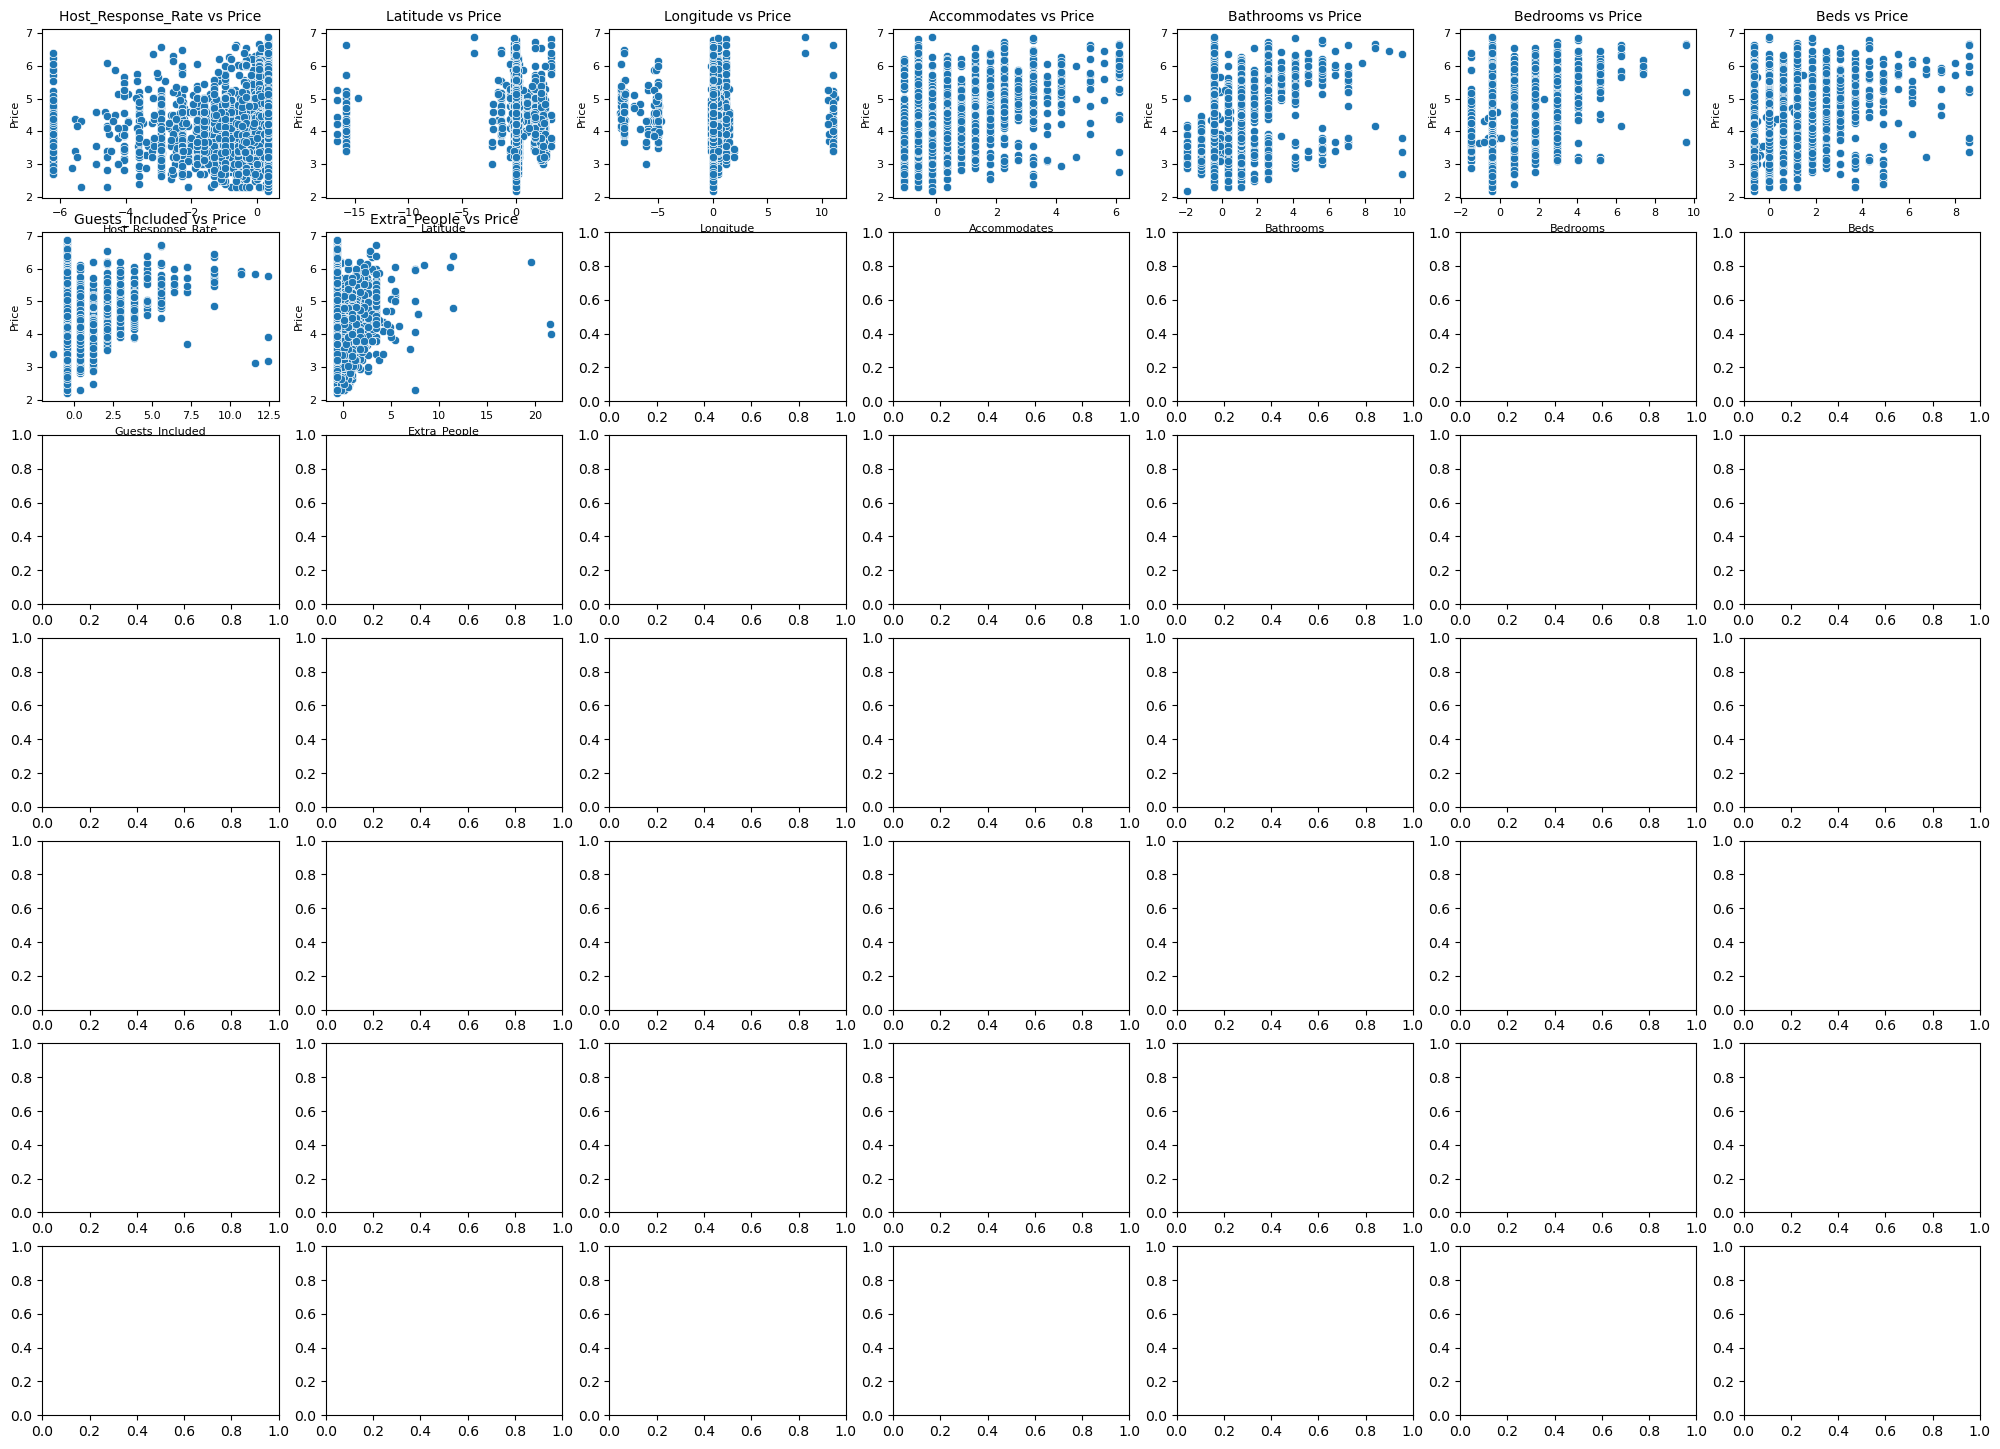

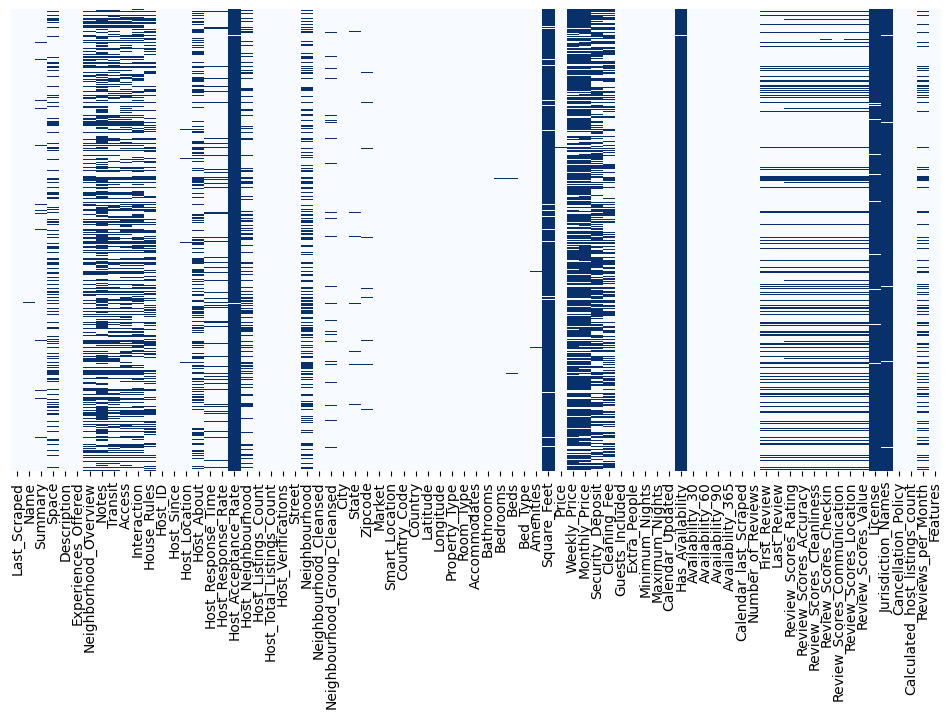

In [209]:
# Checking for missing data
plt.figure(figsize=(12, 6)) 
sns.heatmap(df.isnull(), yticklabels = False, xticklabels=True, cbar=False, cmap='Blues')
plt.show()

In [210]:
# Drop all null (and nearly all null) columns
df.drop(['Host_Acceptance_Rate', 'Square_Feet', 'Has_Availability', 'License', 'Jurisdiction_Names'], axis=1, inplace=True)

<h3 style="background-color:#EBF5FB; color:#2471A3;">Feature engineering: dealing with categorical data</h3>

In [211]:
# Select categorical features only
categorical_df = df.select_dtypes(include=['object'])
categorical_df.head()

Last_Scraped                                            Name  \
0   2017-04-08                PISO ATOCHA- FLAT NEAR ATOCHA  .   
1   2017-04-08                          The Palace Sol Madrid.   
2   2017-04-08  por persona la noche metro linea5 vista alegre   
3   2017-04-08             CITY CENTER JACINTO BENAVENTE ROOM4   
4   2017-04-08              NICE & BIG DOUBLE ROOM AT DOWNTOWN   

                                             Summary  \
0  Piso recién reformado cómoda habitación con ba...   
1  Lugares de interés: Plaza Mayor, Plaza del Sol...   
2  我的房源靠近餐厅和餐饮、适合家庭的活动、公共交通。因为舒适的床、温馨、厨房、景观,您一定会爱...   
3  This stunning and amazig room is covered with ...   
4                                                NaN   

                                               Space  \
0  Un piso muy cómodo en Jerónimos, una de las zo...   
1  El apartamento dispone de un dormitorio indepe...   
2                                                NaN   
3                                                NaN   
4  We are a young couple; David (Spain) and Ana (...   

                                         Description Experiences_Offered  \
0  Piso recién reformado cómoda habitación con ba...                none   
1  Lugares de interés: Plaza Mayor, Plaza del Sol...                none   
2  我的房源靠近餐厅和餐饮、适合家庭的活动、公共交通。因为舒适的床、温馨、厨房、景观,您一定会爱...                none   
3  This stunning and amazig room is covered with ...                none   
4  We are a young couple; David (Spain) and Ana (...                none   

                               Neighborhood_Overview  \
0  El barrio de Jeronimos es un enclave tranquilo...   
1  Situado en el corazón de Madrid, este apartame...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                               Notes  \
0  Facilitamos guía de eventos y rutas turísticas...   
1  Hora llegada: a partir de las 15:00 horas Hora...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             Transit  \
0  Excelente ubicación a tan solo 5 minutos andan...   
1  Acceso a todos los medios de trasporte, BUS, M...   
2  羚羊Casa出发 --地铁Metro 5号线vsita alegre--opera转乘2号线...   
3                                                NaN   
4                                                NaN   

                                              Access  \
0  La conexión a internet por fibra óptica 100 MB...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  WE CAN DO TO HOST COLLECTION SERVICE FROM THE ...   

                                         Interaction  \
0  Recibimos personalmente a nuestros huéspedes y...   
1  Estimado huésped estaremos disponible todo el ...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         House_Rules  Host_Since  \
0  El apartamento se encuentra en un edificio res...  2015-04-13   
1  - Oír música con volumen moderado. Entrada a p...  2016-07-22   
2                                                NaN  2016-07-17   
3                                                NaN  2014-05-08   
4  In the apartment smoking is not allowed, but i...  2012-02-06   

                               Host_Location  \
0  Arroyomolinos, Comunidad de Madrid, Spain   
1         Madrid, Community of Madrid, Spain   
2         Madrid, Community of Madrid, Spain   
3         Madrid, Community of Madrid, Spain   
4         Madrid, Community of Madrid, Spain   

                                          Host_About  Host_Response_Time  \
0              

<p style="background-color:#EBF5FB; color:#2471A3;">Finding low cardinality categorical features to be encoded.</p>

In [212]:
# Finding low cardinality categorical features

unique_values_dict = {column: categorical_df[column].nunique() for column in categorical_df.columns}
unique_values_df = pd.DataFrame(list(unique_values_dict.items()), columns=['Column', 'Unique Values'])

unique_values_df

Column  Unique Values
0                   Last_Scraped             37
1                           Name          11523
2                        Summary          10686
3                          Space           8200
4                    Description          11459
5            Experiences_Offered              5
6          Neighborhood_Overview           6426
7                          Notes           3822
8                        Transit           6353
9                         Access           5781
10                   Interaction           5374
11                   House_Rules           6494
12                    Host_Since           2043
13                 Host_Location            497
14                    Host_About           4248
15            Host_Response_Time              4
16            Host_Neighbourhood            353
17            Host_Verifications            190
18                        Street           1438
19                 Neighbourhood            351
20        Neighbourhood_Cleansed            444
21  Neighbourhood_Group_Cleansed             47
22                          City            222
23                         State             93
24                       Zipcode            535
25                        Market             42
26                Smart_Location            232
27                  Country_Code             18
28                       Country             17
29                 Property_Type             21
30                     Room_Type              3
31                      Bed_Type              5
32                     Amenities          10077
33              Calendar_Updated             57
34         Calendar_last_Scraped             38
35                  First_Review           1583
36                   Last_Review            730
37           Cancellation_Policy              8
38                      Features             86

<p style="background-color:#FDEBD0;"><b>Observation: </b>Low cardinality features (Cancellation_Policy, Bed_Type, Room_Type, Host_Response_Time, Experiences_Offered) can be considered to be encoded as ordinal or one-hot features.</p>

In [213]:
print(categorical_df.Experiences_Offered.value_counts())
print('-'* 20)
print(categorical_df.Room_Type.value_counts())
print('-'* 20)
print(categorical_df.Bed_Type.value_counts())
print('-'* 20)
print(categorical_df.Cancellation_Policy.value_counts())
print('-'* 20)
print(categorical_df.Host_Response_Time.value_counts())

Experiences_Offered
none        11810
business        6
family          3
social          3
romantic        2
Name: count, dtype: int64
--------------------
Room_Type
Entire home/apt    7191
Private room       4471
Shared room         162
Name: count, dtype: int64
--------------------
Bed_Type
Real Bed         11565
Pull-out Sofa      201
Futon               36
Couch               17
Airbed               5
Name: count, dtype: int64
--------------------
Cancellation_Policy
strict             4590
flexible           3756
moderate           3376
strict_new           30
super_strict_60      24
moderate_new         18
super_strict_30      17
flexible_new         13
Name: count, dtype: int64
--------------------
Host_Response_Time
within an hour        6337
within a few hours    2291
within a day          1448
a few days or more     241
Name: count, dtype: int64


<p style="background-color:#FDEBD0;"><b>Observations: </b>Factors with low counts in Experiences_Offered and Bed_Type could be collapsed into one single factor, creating in this way a binary feature.</p>
<p style="background-color:#FDEBD0;">Cancellation_Policy will be collapsed into 3 factors only, that can be encoded ordinally according to the level of flexibility in cancellation policy.</p>
<p style="background-color:#FDEBD0;">Host_Response_Time and Room_Type appears to have more obervations distributed across its factors, so the factors could be kept and recoded to an ordinal feature. I will explore Room_Type and Host_Response_Time relation to Price to see whether the factors would be better collapsed or preserved.</p>

<p style="background-color:#EBF5FB; color:#2471A3;">--------------------------------------------------------------------------------------------------------------------------------------------</p>

<p style="background-color:#EBF5FB; color:#2471A3;">Encoding to ordinal features</p>

In [214]:
# Encoding to ordinal features 

categorical_df['Experiences_Offered'] = categorical_df['Experiences_Offered'].apply(lambda x: 0 if x=='none' else 1)

categorical_df['Bed_Type'] = categorical_df['Bed_Type'].apply(lambda x: 1 if x=='Real Bed' else 0)

category_mapping_cp = {
    'strict': 0,
    'moderate': 1,
    'flexible': 2,
    'strict_new': 0,
    'super_strict_60': 0,
    'super_strict_30': 0,
    'moderate_new': 1,
    'flexible_new': 2,
}

categorical_df['Cancellation_Policy'] = categorical_df['Cancellation_Policy'].map(category_mapping_cp)

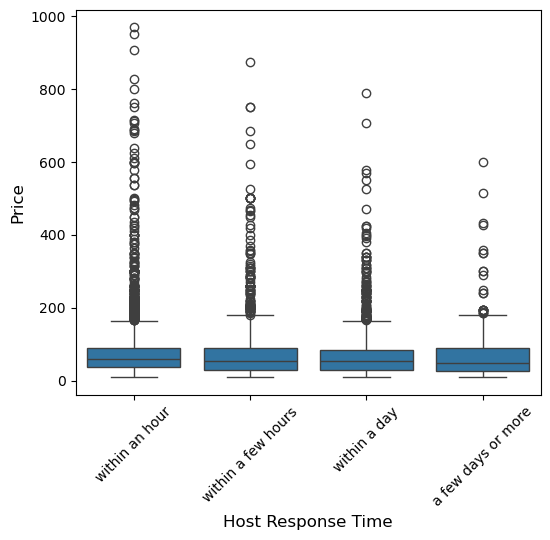

In [215]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='Host_Response_Time', y='Price', data=df, order=['within an hour', 'within a few hours', 'within a day', 'a few days or more'])

plt.xlabel('Host Response Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)

plt.show()

In [216]:
category_mapping_hrt = {
    'within an hour': 0,
    'within a few hours': 1,
    'within a day': 2, 
    'a few days or more': 3
}
categorical_df['Host_Response_Time'] = categorical_df['Host_Response_Time'].map(category_mapping_hrt)

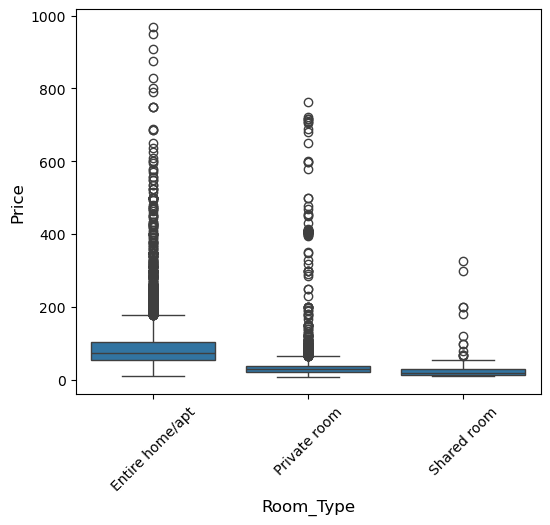

In [217]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='Room_Type', y='Price', data=df, order=['Entire home/apt', 'Private room', 'Shared room'])

plt.xlabel('Room_Type', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)

plt.show()

In [218]:
category_mapping_rt = {
    'Entire home/apt': 2, 
    'Private room': 1, 
    'Shared room': 0
}
categorical_df['Room_Type'] = categorical_df['Room_Type'].map(category_mapping_rt)

In [219]:
categorical_df.sample(2)

Last_Scraped                                      Name  \
8155    2017-03-15  R.058 Amazing eighteenth century mansion   
10811   2017-04-08          Habitación privada de matrimonio   

                                                 Summary  \
8155   Beautiful rural Mallorcan property dating back...   
10811  Habitación privada de matrimonio con cama de 1...   

                                                   Space  \
8155   Beautiful rural Mallorcan property dating back...   
10811  El apartamento es precioso y está situado en l...   

                                             Description  Experiences_Offered  \
8155   Beautiful rural Mallorcan property dating back...                    0   
10811  Habitación privada de matrimonio con cama de 1...                    0   

                                   Neighborhood_Overview Notes  \
8155                                                 NaN   NaN   
10811  Es un barrio lleno de tiendas próximo al centr...   NaN   

                             Transit  \
8155                             NaN   
10811  Metro y autobuses a 10 metros   

                                                  Access  \
8155                                                 NaN   
10811  Todo el apartamento está incluido en la reserv...   

                                             Interaction  \
8155                                                 NaN   
10811  Mi atención a los huéspedes será del 100 por 1...   

                                             House_Rules  Host_Since  \
8155   - Se permiten animales de compañía bajo consul...  2013-03-21   
10811                     Que sean respetuosos y limpios  2016-04-27   

                            Host_Location  \
8155     Alcúdia, Balearic Islands, Spain   
10811  Madrid, Community of Madrid, Spain   

                                              Host_About  Host_Response_Time  \
8155   Hola a todos! Somos Anna y Marga. Actualmente ...                 2.0   
10811             Soy una chica muy sociable y divertida                 0.0   

      Host_Neighbourhood                              Host_Verifications  \
8155                 NaN                       email,phone,reviews,jumio   
10811                NaN  email,phone,google,reviews,jumio,government_id   

                                         Street Neighbourhood  \
8155    Felanitx, Balearic Islands 07200, Spain           NaN   
10811  Madrid, Comunidad de Madrid 28027, Spain           NaN   

      Neighbourhood_Cleansed Neighbourhood_Group_Cleansed      City  \
8155                 Manacor                          NaN  Felanitx   
10811               Quintana                Ciudad Lineal    Madrid   

                     State Zipcode           Market   Smart_Location  \
8155      Balearic Islands   07200  Mallorca Island  Felanitx, Spain   
10811  Comunidad de Madrid   28027           Madrid    Madrid, Spain   

      Country_Code Country Property_Type  Room_Type  Bed_Type  \
8155            ES   Spain         House          2         1   
10811           ES   Spain     Apartment          1         1   

                                               Amenities Calendar_Updated  \
8155   TV,Cable TV,Internet,Wireless Internet,Pool,Ki...            today   
10811  Smoking allowed,Pets allowed,Family/kid friend...     3 months ago   

      Calendar_last_Scraped First_Review Last_Review  Cancellation_Policy  \
8155             2017-03-15   2014-06-02  2016-08-21                    0   
10811            2017-04-08          NaN         NaN                    0   

                                                Features  
8155   Host Has Profile Pic,Host Identity Verified,Is...  
10811  Host Has Profile Pic,Host Identity Verified,Re...

<p style="background-color:#EBF5FB; color:#2471A3;">--------------------------------------------------------------------------------------------------------------------------------------------</p>

<p style="background-color:#EBF5FB; color:#2471A3;">Exploring date features and their relation to Price</p>

In [220]:
df['Last_Scraped'] = pd.to_datetime(df['Last_Scraped'])
sorted_df = df.sort_values(by='Last_Scraped')
date_difference = sorted_df['Last_Scraped'].iloc[-1] - sorted_df['Last_Scraped'].iloc[0]
print(date_difference)

528 days 00:00:00


In [221]:
df['Calendar_last_Scraped'] = pd.to_datetime(df['Calendar_last_Scraped'])
sorted_df = df.sort_values(by='Calendar_last_Scraped')
date_difference = sorted_df['Calendar_last_Scraped'].iloc[-1] - sorted_df['Calendar_last_Scraped'].iloc[0]
print(date_difference)

528 days 00:00:00


In [222]:
categorical_df.Calendar_Updated.value_counts()

Calendar_Updated
today            3105
2 weeks ago       982
yesterday         968
a week ago        914
3 days ago        651
4 days ago        551
2 months ago      463
3 weeks ago       438
5 days ago        424
4 weeks ago       366
2 days ago        305
5 weeks ago       288
3 months ago      268
6 weeks ago       223
4 months ago      186
6 days ago        185
5 months ago      166
6 months ago      154
7 months ago      130
9 months ago      126
7 weeks ago       122
8 months ago      108
never              93
1 week ago         76
10 months ago      76
11 months ago      53
15 months ago      43
12 months ago      42
13 months ago      41
14 months ago      37
16 months ago      34
21 months ago      32
20 months ago      29
22 months ago      27
17 months ago      25
19 months ago      23
18 months ago      23
24 months ago      11
23 months ago       8
29 months ago       5
26 months ago       3
25 months ago       2
48 months ago       2
30 months ago       2
31 months ago  

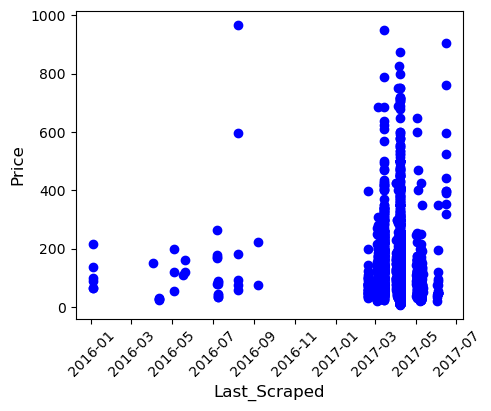

In [223]:
plt.figure(figsize=(5, 4))
plt.scatter(sorted_df['Last_Scraped'], sorted_df['Price'], color='blue')
plt.xlabel('Last_Scraped', fontsize=12, )
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45) 
plt.show()

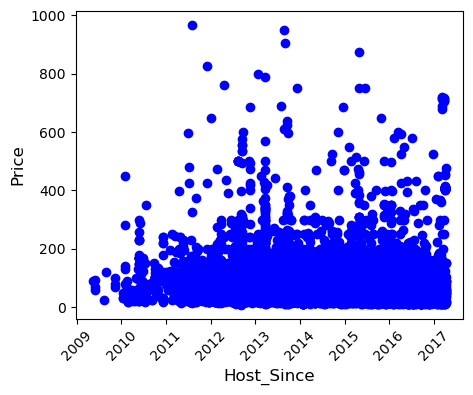

In [224]:
df['Host_Since'] = pd.to_datetime(df['Host_Since'])
sorted_df = df.sort_values(by='Host_Since')
plt.figure(figsize=(5, 4))
plt.scatter(sorted_df['Host_Since'], sorted_df['Price'], color='blue')
plt.xlabel('Host_Since', fontsize=12, )
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45) 
plt.show()

In [225]:
# Drop the date columns
categorical_df.drop(['Last_Scraped', 'Calendar_last_Scraped', 'Calendar_Updated', 'First_Review', 'Last_Review', 'Host_Since'], axis=1, inplace=True)

In [226]:
categorical_df.sample(2)

Name  \
7429                    Aptto. Gran Via   
4800  Bedroom & bathroom luxurious apt.   

                                                Summary  \
7429  En C/Fuencarral, peatonal, a 5 min. de Gran Vi...   
4800  Large bedroom with a double bed and a private ...   

                                                  Space  \
7429  Se trata de un apartamento de unos 40 m2 , con...   
4800                                                NaN   

                                            Description  Experiences_Offered  \
7429  En C/Fuencarral, peatonal, a 5 min. de Gran Vi...                    0   
4800  Large bedroom with a double bed and a private ...                    0   

                                  Neighborhood_Overview Notes  \
7429  Para mantener la buena armonia con el vecindar...   NaN   
4800                                                NaN   NaN   

                                                Transit  \
7429  Hay multiples líneas de autobus y metro , asi ...   
4800                                                NaN   

                                                 Access  \
7429  Incluimos sabanas y toallas limpias. Nos adapt...   
4800                                                NaN   

                                        Interaction  \
7429  No dudes en preguntar lo que no tengas claro.   
4800                                            NaN   

                                            House_Rules  \
7429  No fumadores , no mascotas , NO MAS DE 2 PERSO...   
4800  Please treat the house like you would treat yo...   

                           Host_Location Host_About  Host_Response_Time  \
7429  Madrid, Community of Madrid, Spain        NaN                 0.0   
4800  Madrid, Community of Madrid, Spain        NaN                 NaN   

     Host_Neighbourhood                       Host_Verifications  \
7429           Justicia                      email,phone,reviews   
4800          Docklands  email,phone,reviews,jumio,government_id   

                                                 Street Neighbourhood  \
7429  Justicia, Madrid, Community of Madrid 28004, S...      Justicia   
4800                            Dublin, Dublin, Ireland           NaN   

     Neighbourhood_Cleansed Neighbourhood_Group_Cleansed    City  \
7429               Justicia                       Centro  Madrid   
4800            Dublin City                          NaN  Dublin   

                    State Zipcode  Market   Smart_Location Country_Code  \
7429  Community of Madrid   28004  Madrid    Madrid, Spain           ES   
4800               Dublin     NaN  Dublin  Dublin, Ireland           IE   

      Country Property_Type  Room_Type  Bed_Type  \
7429    Spain     Apartment          2         1   
4800  Ireland     Apartment          1         1   

                                              Amenities  Cancellation_Policy  \
7429  TV,Cable TV,Internet,Wireless Internet,Air con...                    2   
4800  TV,Internet,Wireless Internet,Kitchen,Free par...                    1   

                                               Features  
7429  Host Has Profile Pic,Is Location Exact,Require...  
4800        Host Has Profile Pic,Host Identity Verified

<p style="background-color:#EBF5FB; color:#2471A3;">--------------------------------------------------------------------------------------------------------------------------------------------</p>

<h3 style="background-color:#EBF5FB; color:#2471A3;">Feature engineering: dealing with text data</h3>

I will explore the following features that could have a impact on Price: Host_verification, Neighbourhood_Group_Cleansed, Market, Country, Amenities, Features, Description, House_Rules and Transit.

<p style="background-color:#EBF5FB; color:#2471A3;">Exploring Host_Verifications feature</p>

In [227]:
pd.set_option('display.max_colwidth', None)
categorical_df['Host_Verifications'].sample(10)

8474                                    email,phone,facebook,reviews,jumio
8258                                                   email,phone,reviews
9100                                             email,phone,reviews,jumio
905                                     email,phone,linkedin,reviews,jumio
4424     email,phone,manual_online,reviews,manual_offline,jumio,work_email
9387                      email,phone,facebook,reviews,jumio,government_id
9211                                                   email,phone,reviews
981                         email,phone,google,reviews,jumio,government_id
10943                                            email,phone,reviews,jumio
11762                                                  email,phone,reviews
Name: Host_Verifications, dtype: object

In [228]:
pd.reset_option('display.max_colwidth')

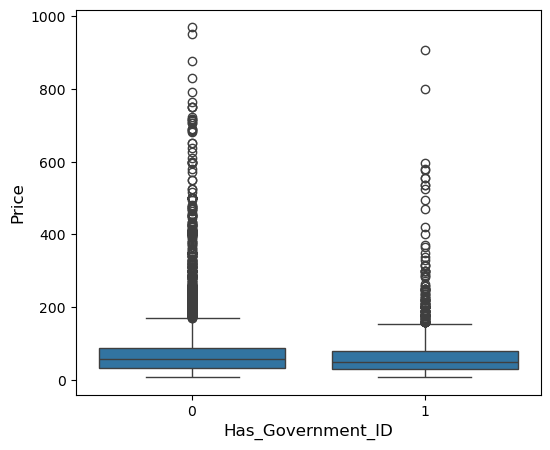

In [229]:
# Explore whether having 'goverment_id' among verification types is related to Price

df['Has_Government_ID'] = df['Host_Verifications'].fillna('').str.contains('government_id').astype(int)

plt.figure(figsize=(6, 5))
sns.boxplot(x='Has_Government_ID', y='Price', data=df)
plt.xlabel('Has_Government_ID', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()


<p style="background-color:#FDEBD0;"><b>Observations: </b>It appears that Has_Government_ID is not related to Price difference. I will drop this feature.</p>

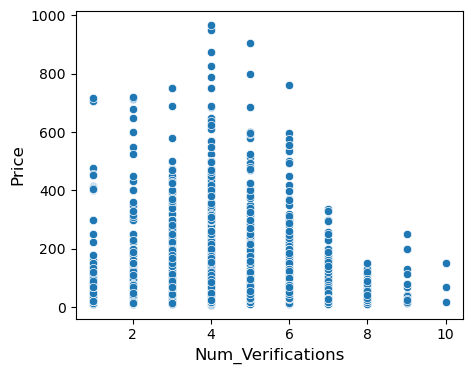

In [230]:
# Encode Host_Verifications as a function of the number of different verification types

df['Num_Verifications'] = df['Host_Verifications'].fillna('').str.split(',').str.len()

# Visualize Num_Verifications vs. Price
plt.figure(figsize=(5, 4))
sns.scatterplot(x='Num_Verifications', y='Price', data=df)
plt.xlabel('Num_Verifications', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [231]:
# Store the synthetic feature in the categorical_df
categorical_df['Num_Verifications'] = categorical_df['Host_Verifications'].fillna('').str.split(',').str.len()
categorical_df.loc[categorical_df['Host_Verifications'].isna(), 'Num_Verifications'] = np.nan # convert original NaN back to NaN

# Drop 'Host_Verifications', 'Has_Government_ID'
categorical_df.drop(['Host_Verifications'], axis=1, inplace=True)
df.drop(['Has_Government_ID', 'Num_Verifications'], axis=1, inplace=True)

<p style="background-color:#EBF5FB; color:#2471A3;">--------------------------------------------------------------------------------------------------------------------------------------------</p>

<p style="background-color:#EBF5FB; color:#2471A3;">Exploring Summary and Description features</p>

In [232]:
# Check the difference in missing values
print('Not-null values in Summary:', categorical_df['Summary'].notnull().sum())
print('Not-null values in Description:', categorical_df['Description'].notnull().sum())

Not-null values in Summary: 11355
Not-null values in Description: 11818


In [233]:
# How many observations where Summary == Description?
df['is_equal'] = categorical_df['Summary'] == categorical_df['Description']
print(df['is_equal'].sum())

2635


In [234]:
# Display rows where they are not equal
not_equal_df = categorical_df[df['is_equal'] == False]
pd.set_option('display.max_colwidth', None)
not_equal_df.sample(1)

Name  \
3437  Appartement 70 squared meter Madrid   

                                                                                                                                                                                                                      Summary  \
3437  Appartement in a well sustained building, guarded from monday to friday from 8am to 8pm. 70 squared meters. Big kitchen, big bedroom and living room and big bathroom 5 minutes walking from Castellana, 3 from Serrano   

     Space  \
3437   NaN   

                                                                                                                                                                                                                                                                                                                                                                                            Description  \
3437  Appartement in a well sustained building, guarded from monday to friday from 8am to 8pm. 70 squared meters. Big kitchen, big bedroom and living room and big bathroom 5 minutes walking from Castellana, 3 from Serrano Heater, air conditioner, full equipped kitchen and bathroom Nice neighborhood near the main and mot beautiful places in madrid 2 metro stations at 5 minutes walking each   

      Experiences_Offered  \
3437                    0   

                                                   Neighborhood_Overview  \
3437  Nice neighborhood near the main and mot beautiful places in madrid   

     Notes                                     Transit  \
3437   NaN  2 metro stations at 5 minutes walking each   

                                                           Access Interaction  \
3437  Heater, air conditioner, full equipped kitchen and bathroom         NaN   

     House_Rules                       Host_Location Host_About  \
3437         NaN  Madrid, Community of Madrid, Spain        NaN   

      Host_Response_Time Host_Neighbourhood  \
3437                 NaN         Castellana   

                                                    Street Neighbourhood  \
3437  Castellana, Madrid, Comunidad de Madrid 28006, Spain    Castellana   

     Neighbourhood_Cleansed Neighbourhood_Group_Cleansed    City  \
3437             Castellana                    Salamanca  Madrid   

                    State Zipcode  Market Smart_Location Country_Code Country  \
3437  Comunidad de Madrid   28006  Madrid  Madrid, Spain           ES   Spain   

     Property_Type  Room_Type  Bed_Type  \
3437     Apartment          2         1   

                                                                                      Amenities  \
3437  TV,Internet,Wireless Internet,Air conditioning,Kitchen,Smoking allowed,Heating,Dryer,Iron   

      Cancellation_Policy  \
3437                    0   

                                                     Features  \
3437  Host Has Profile Pic,Is Location Exact,Requires License   

      Num_Verifications  
3437                3.0

In [235]:
pd.reset_option('display.max_colwidth')

<p style="background-color:#FDEBD0;"><b>Observations: </b>It seems that Description is the combination of Summary and Space fields. However, it seems that Description can be written in different languages what can complicate feature extraction. Let's chcek what language there are and how many observation belong to each.</p>

In [236]:

!pip install langdetect
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0
def detect_language(text):
    try:
        return detect(text)
    except:
        return None 
    
categorical_df['Detected_language'] = categorical_df['Description'].apply(detect_language)

In [237]:
categorical_df['Detected_language'].value_counts()

Detected_language
en       6256
es       5414
fr         47
it         33
pt         27
de         19
ru          5
ca          4
nl          3
zh-cn       3
lt          2
vi          2
id          1
da          1
tl          1
Name: count, dtype: int64

In [238]:
categorical_df['Country'].value_counts()

Country
Spain             11203
United States       139
United Kingdom      127
France               87
Italy                61
Australia            38
Ireland              34
Germany              33
Austria              26
Netherlands          19
Belgium              16
Canada               16
Denmark              14
Switzerland           4
Greece                3
Hong Kong             2
Cuba                  1
Name: count, dtype: int64

<p style="background-color:#FDEBD0;"><b>Observations: </b>Because of the language complexity of these features, I will set them aside. I will consider including them (after vectorization and feature extraction) depending on the performance of the model. However, I will generate a new variable 'Directed_at_Foreigners' that will be binary reflecting whether the ad was written in English if English is not an official language of the country the house is in. This feaure may be of interest in predicting Price, as ads directed at foreigners (turists) may be likely more expensive.</p>

In [239]:
# Drop the text columns that include different languages
categorical_df.drop(['Summary', 'Description', 'Space', 'Name', 'Neighborhood_Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House_Rules', 'Host_About'], axis=1, inplace=True)

In [240]:
categorical_df['Directed_at_Foreigners'] = categorical_df.apply(
    lambda row: 1 if (row['Detected_language'] == 'en' and row['Country'] not in ['United States', 'United Kingdom', 'Ireland', 'Canada']) else 0, axis=1
)

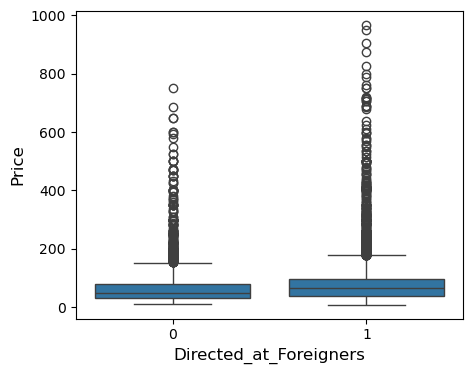

In [241]:
# Explore whether having 'Dicrected_at_Foreigners' among verification types is related to Price

plt.figure(figsize=(5, 4))
sns.boxplot(x=categorical_df['Directed_at_Foreigners'], y=df['Price'])
plt.xlabel('Directed_at_Foreigners', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [242]:
# Drop the generated 'Detected_language' column
categorical_df.drop(['Detected_language'], axis=1, inplace=True)

<p style="background-color:#EBF5FB; color:#2471A3;">--------------------------------------------------------------------------------------------------------------------------------------------</p>

<p style="background-color:#EBF5FB; color:#2471A3;">Exploring other text data</p>

<p style="background-color:#FDEBD0;"><b>Observations: </b>The rest of the text columns were not encoded into categorical variables due to high number of factors. Location data such as Neighbourhood, City, Country, etc., will be droped given that Lattitude and Longitude already encode this information, making the other features redundant.From among the remaining features, I will extract relevant aspects from the Amenities feature.</p>

In [243]:
categorical_df.drop(['Features', 'Neighbourhood_Group_Cleansed', 'Smart_Location', 'Property_Type', 'Country', 'Country_Code', 'Market', 'Zipcode', 'State', 'City', 'Neighbourhood_Cleansed', 'Neighbourhood', 'Street', 'Host_Neighbourhood', 'Host_Location'], axis=1, inplace=True)

In [244]:
# Find unique amenity types
categorical_df['Amenities'] = categorical_df['Amenities'].fillna('nan').str.lower().str.split(',')
unique_amenities = set(amenity.strip() for sublist in categorical_df['Amenities'] for amenity in sublist if amenity.strip())
print(unique_amenities)

{'children’s dinnerware', 'tv', 'baby bath', 'gym', 'pets allowed', 'window guards', 'high chair', 'microwave', 'laptop friendly workspace', 'extra pillows and blankets', 'dishes and silverware', 'translation missing: en.hosting_amenity_49', 'path to entrance lit at night', 'washer / dryer', 'wheelchair accessible', 'elevator in building', 'translation missing: en.hosting_amenity_50', 'hot tub', 'suitable for events', 'garden or backyard', 'pets live on this property', 'breakfast', 'nan', 'luggage dropoff allowed', 'dryer', 'table corner guards', 'essentials', 'safety card', 'babysitter recommendations', 'lockbox', 'patio or balcony', 'free parking on premises', 'carbon monoxide detector', 'kitchen', 'iron', 'coffee maker', 'fire extinguisher', 'wireless internet', 'dog(s)', 'internet', 'smoking allowed', 'keypad', 'paid parking off premises', 'changing table', 'hair dryer', 'smoke detector', 'shampoo', 'refrigerator', '24-hour check-in', 'stair gates', 'other pet(s)', 'self check-in',

In [245]:
# Show amenity type and number of observations per amenity
exploded_df = categorical_df['Amenities'].explode()

amenity_counts = exploded_df.str.strip().value_counts()
amenity_counts_df = amenity_counts.reset_index()
amenity_counts_df.columns = ['Amenity', 'Count']

amenity_counts_df.T

0        1        2           3       4     5   \
Amenity  wireless internet  kitchen  heating  essentials  washer    tv   
Count                11093    10887    10649       10131    9980  9236   

              6        7                    8                     9     10  \
Amenity  hangers  shampoo  family/kid friendly  elevator in building  iron   
Count       7760     7322                 7135                  6869  6754   

               11          12                13                         14  \
Amenity  internet  hair dryer  air conditioning  laptop friendly workspace   
Count        6724        6585              6398                       5968   

                               15                                          16  \
Amenity  buzzer/wireless intercom  translation missing: en.hosting_amenity_50   
Count                        5277                                        3454   

                    17               18                19  \
Amenity  first aid kit  smoking allowed  24-hour check-in   
Count             3061             3060              2892   

                                                 20     21       22  \
Amenity  translation missing: en.hosting_amenity_49  dryer  doorman   
Count                                          2735   2265     2101   

                        23              24            25         26        27  \
Amenity  fire extinguisher  smoke detector  pets allowed  breakfast  cable tv   
Count                 2047            2036          2004       1766      1416   

                               28                     29           30  \
Amenity  carbon monoxide detector  wheelchair accessible  safety card   
Count                        1384                   1212         1203   

                           31                        32    33  \
Amenity  lock on bedroom door  free parking on premises  pool   
Count                    1061                      1057   719   

                                 34                   35                36  \
Amenity  pets live on this property  suitable for events  indoor fireplace   
Count                           697                  550               471   

                       37       38             39      40      41   42  \
Amenity  private entrance  hot tub  self check-in  cat(s)  dog(s)  gym   
Count                 363      338            285     274     264  260   

                          43             44   45       46       47  \
Amenity  private living room  doorman entry  nan  bathtub  lockbox   
Count                    213            166  141       75       75   

                            48            49    50         51      52  \
Amenity  room-darkening shades  other pet(s)  crib  smartlock  keypad   
Count                       43            32    24         22      22   

                               53             54                         55  \
Amenity  pack ’n play/travel crib  window guards  children’s books and toys   
Count                          17             14                         13   

                 56                     57         58  \
Amenity  high chair  children’s dinnerware  baby bath   
Count            12                     11         10   

                                 59             60            61  \
Amenity  babysitter recommendations  outlet covers  game console   
Count                             8              6             6   

                             62           63                         64  \
Amenity  free parking on street  stair gates  paid parking off premises   
Count                         5            4                          3   

                          65              66                          67  \
Amenity  table corner guards  washer / dryer  extra pillows and blankets   
Count                      3               2                           1   

                68            69            70          71  \
Amenity 

In [246]:
# Generate binary features corresponding to a selected subset of amenities

selected_amenities = [
    'heating',
    'family/kid friendly',
    'elevator in building',
    'air conditioning',
    'laptop friendly workspace',
    'smoking allowed',
    '24-hour check-in',
    'doorman',
    'pets allowed',
    'breakfast',
    'free parking on premises',
    'pool'
]


In [247]:
# Find if amenity type is present and encode into a feature
for amenity in selected_amenities:
    categorical_df[amenity] = categorical_df['Amenities'].apply(lambda x: 1 if amenity in [a.strip() for a in x] else 0)

categorical_df.loc[categorical_df['Amenities'].apply(lambda x: 'nan' in x), selected_amenities] = np.nan

In [248]:
# Drop original amenities column
categorical_df.drop(['Amenities'], axis=1, inplace=True)

categorical_df.sample(5)

Experiences_Offered  Host_Response_Time  Room_Type  Bed_Type  \
6666                     0                 1.0          1         1   
10360                    0                 0.0          2         1   
4143                     0                 2.0          1         1   
10491                    0                 1.0          1         1   
256                      0                 1.0          1         1   

       Cancellation_Policy  Num_Verifications  Directed_at_Foreigners  \
6666                     1                6.0                       0   
10360                    2                4.0                       1   
4143                     1                6.0                       1   
10491                    0                4.0                       0   
256                      1                4.0                       0   

       heating  family/kid friendly  elevator in building  air conditioning  \
6666       1.0                  1.0                   1.0               0.0   
10360      1.0                  0.0                   1.0               1.0   
4143       1.0                  0.0                   0.0               0.0   
10491      1.0                  0.0                   0.0               0.0   
256        1.0                  0.0                   0.0               0.0   

       laptop friendly workspace  smoking allowed  24-hour check-in  doorman  \
6666                         1.0              1.0               0.0      0.0   
10360                        1.0              0.0               0.0      0.0   
4143                         1.0              0.0               1.0      0.0   
10491                        1.0              1.0               0.0      0.0   
256                          1.0              1.0               1.0      0.0   

       pets allowed  breakfast  free parking on premises  pool  
6666            1.0        0.0                       0.0   0.0  
10360           0.0        0.0                       0.0   0.0  
4143            0.0        0.0                       0.0   0.0  
10491           0.0        0.0                       0.0   0.0  
256             0.0        0.0                       0.0   0.0

<p style="background-color:#EBF5FB; color:#2471A3;">--------------------------------------------------------------------------------------------------------------------------------------------</p>

<h3 style="background-color:#EBF5FB; color:#2471A3;">Imputing missing values</h3>

In [249]:
# Select numerical features only
df_numerical = df.select_dtypes(include=['float64', 'int64'])

# Put the target feature aside
target = df_numerical['Price']
df_numerical = df_numerical.drop(['Price'], axis=1)

# Concatinate with engineered categorical features
df_numerical = pd.concat([df_numerical, categorical_df], axis=1)
df_numerical.shape

(11824, 51)

In [250]:
df_numerical.head()

Host_ID  Host_Response_Rate  Host_Listings_Count  \
0  31124866               100.0                  2.0   
1  85301317               100.0                  1.0   
2  84213235               100.0                 16.0   
3  15258781               100.0                114.0   
4   1706029               100.0                  2.0   

   Host_Total_Listings_Count   Latitude  Longitude  Accommodates  Bathrooms  \
0                        2.0  40.407732  -3.684819             4        1.0   
1                        1.0  40.415802  -3.705340             4        1.0   
2                       16.0  40.389048  -3.740374             1        1.5   
3                      114.0  40.412814  -3.703052             2        3.0   
4                        2.0  40.438631  -3.713716             2        1.0   

   Bedrooms  Beds  Weekly_Price  Monthly_Price  Security_Deposit  \
0       1.0   2.0         550.0         1250.0               NaN   
1       1.0   2.0           NaN            NaN               NaN   
2       1.0   8.0           NaN            NaN               NaN   
3       1.0   1.0           NaN            NaN               NaN   
4       1.0   1.0           NaN            NaN               NaN   

   Cleaning_Fee  Guests_Included  Extra_People  Minimum_Nights  \
0          25.0                1             0               2   
1          15.0                1             0               1   
2           5.0                1             0               3   
3           NaN                1             0              10   
4           NaN                1            10               1   

   Maximum_Nights  Availability_30  Availability_60  Availability_90  \
0            1125                9               32               52   
1            1125               15               39               64   
2              30               14               44               74   
3            1125                0                6               36   
4            1125                7               34               62   

   Availability_365  Number_of_Reviews  Review_Scores_Rating  \
0               117                 12                  95.0   
1               208                 20                  91.0   
2               140                  0                   NaN   
3               311                  0                   NaN   
4               337                 97                  92.0   

   Review_Scores_Accuracy  Review_Scores_Cleanliness  Review_Scores_Checkin  \
0                     9.0                       10.0                   10.0   
1                     9.0                        9.0                   10.0   
2                     NaN                        NaN                    NaN   
3                     NaN                        NaN                    NaN   
4                     9.0                        9.0                    9.0   

   Review_Scores_Communication  Review_Scores_Location  Review_Scores_Value  \
0                         10.0                    10.0                  9.0   
1                         10.0                    10.0                 10.0   
2                          NaN                     NaN                  NaN   
3                          NaN                     NaN                  NaN   
4                         10.0                     9.0                  9.0   

   Calculated_host_listings_count  Reviews_per_Month  Experiences_Offered  \
0                             2.0               0.50                    0   
1                             1.0               2.43                    0   
2                            16.0                NaN                    0   
3                            97.0                NaN                    0   
4                             2.0               2.08                    0   

   Host_Response_Time  Room_Type  Bed_Type  Cancellation_Policy  \
0                 1.0          2         1                    1   
1                 0.0

In [251]:
df_numerical.drop(['Host_Listings_Count', 'Host_Total_Listings_Count', 'Host_ID', 'Calculated_host_listings_count'], axis=1, inplace=True)

In [252]:
# Check if Security_Deposit & Cleaning_Fee contains 0 as a value, otherwise NAN could be set a constant = 0
if (df_numerical['Security_Deposit'] == 0).any():
    print('Security_Deposit has 0 as a value.')
if (df_numerical['Cleaning_Fee'] == 0).any():
    print('Cleaning_Fee has 0 as a value.')

Security_Deposit has 0 as a value.
Cleaning_Fee has 0 as a value.


In [253]:
# Check data distributions and outliers before deciding on imputation strategy
df_numerical.describe()

Host_Response_Rate      Latitude     Longitude  Accommodates  \
count        10317.000000  11824.000000  11824.000000  11824.000000   
mean            94.803722     40.491628     -3.776863      3.277486   
std             15.247078      4.701030     14.014695      2.093973   
min              0.000000    -37.851182   -123.124429      1.000000   
25%            100.000000     40.409758     -3.707538      2.000000   
50%            100.000000     40.419331     -3.700763      3.000000   
75%            100.000000     40.430778     -3.683917      4.000000   
max            100.000000     55.966912    153.371427     16.000000   

          Bathrooms     Bedrooms          Beds  Weekly_Price  Monthly_Price  \
count  11780.000000  11804.00000  11787.000000   2881.000000    2869.000000   
mean       1.285229      1.34429      2.049122    378.437348    1432.390728   
std        0.664691      0.90518      1.623489    194.751472    1236.992934   
min        0.000000      0.00000      1.000000     70.000000     250.000000   
25%        1.000000      1.00000      1.000000    220.000000     720.000000   
50%        1.000000      1.00000      2.000000    350.000000    1200.000000   
75%        1.000000      2.00000      2.000000    500.000000    1750.000000   
max        8.000000     10.00000     16.000000    999.000000   25000.000000   

       Security_Deposit  Cleaning_Fee  Guests_Included  Extra_People  \
count       5052.000000   6974.000000     11824.000000  11824.000000   
mean         189.312154     32.073129         1.581614      7.637601   
std          116.011858     31.278032         1.160518     12.373491   
min            0.000000      0.000000         0.000000      0.000000   
25%          100.000000     15.000000         1.000000      0.000000   
50%          150.000000     25.000000         1.000000      0.000000   
75%          200.000000     40.000000         2.000000     15.000000   
max          990.000000    662.000000        16.000000    500.000000   

       Minimum_Nights  Maximum_Nights  Availability_30  Availability_60  \
count    11824.000000    11824.000000     11824.000000     11824.000000   
mean         3.109946      961.732070         8.949002        22.949256   
std         13.427477     9387.640642         9.340334        19.762734   
min          1.000000        1.000000         0.000000         0.000000   
25%          1.000000      365.000000         0.000000         4.000000   
50%          2.000000     1125.000000         6.000000        20.000000   
75%          3.000000     1125.000000        14.000000        38.000000   
max       1125.000000  1000000.000000        30.000000        60.000000   

       Availability_90  Availability_365  Number_of_Reviews  \
count     11824.000000      11824.000000       11824.000000   
mean         39.803958        202.217185          22.664834   
std          29.663314        128.006830          38.092338   
min           0.000000          0.000000           0.000000   
25%          11.000000         78.000000           1.000000   
50%          38.000000        240.000000           7.000000   
75%          65.000000        319.000000          27.000000   
max          90.000000        365.000000         356.000000   

       Review_Scores_Rating  Review_Scores_Accuracy  \
count           9163.000000             9143.000000   
mean              91.628179                9.410040   
std                9.137614                0.938013   
min               20.000000                2.000000   
25%               89.000000                9.000000   
50%               94.000000               10.000000   
75%               98.000000               10.000000   
max              100.000000               10.000000   

       Review_Scores_Cleanliness  Review_Scores_Checkin  \
count                9148.000000            9136.000000   
mean                    9.320726               9.623905   
std                     1.004472               0.804050   
min                     2.0000

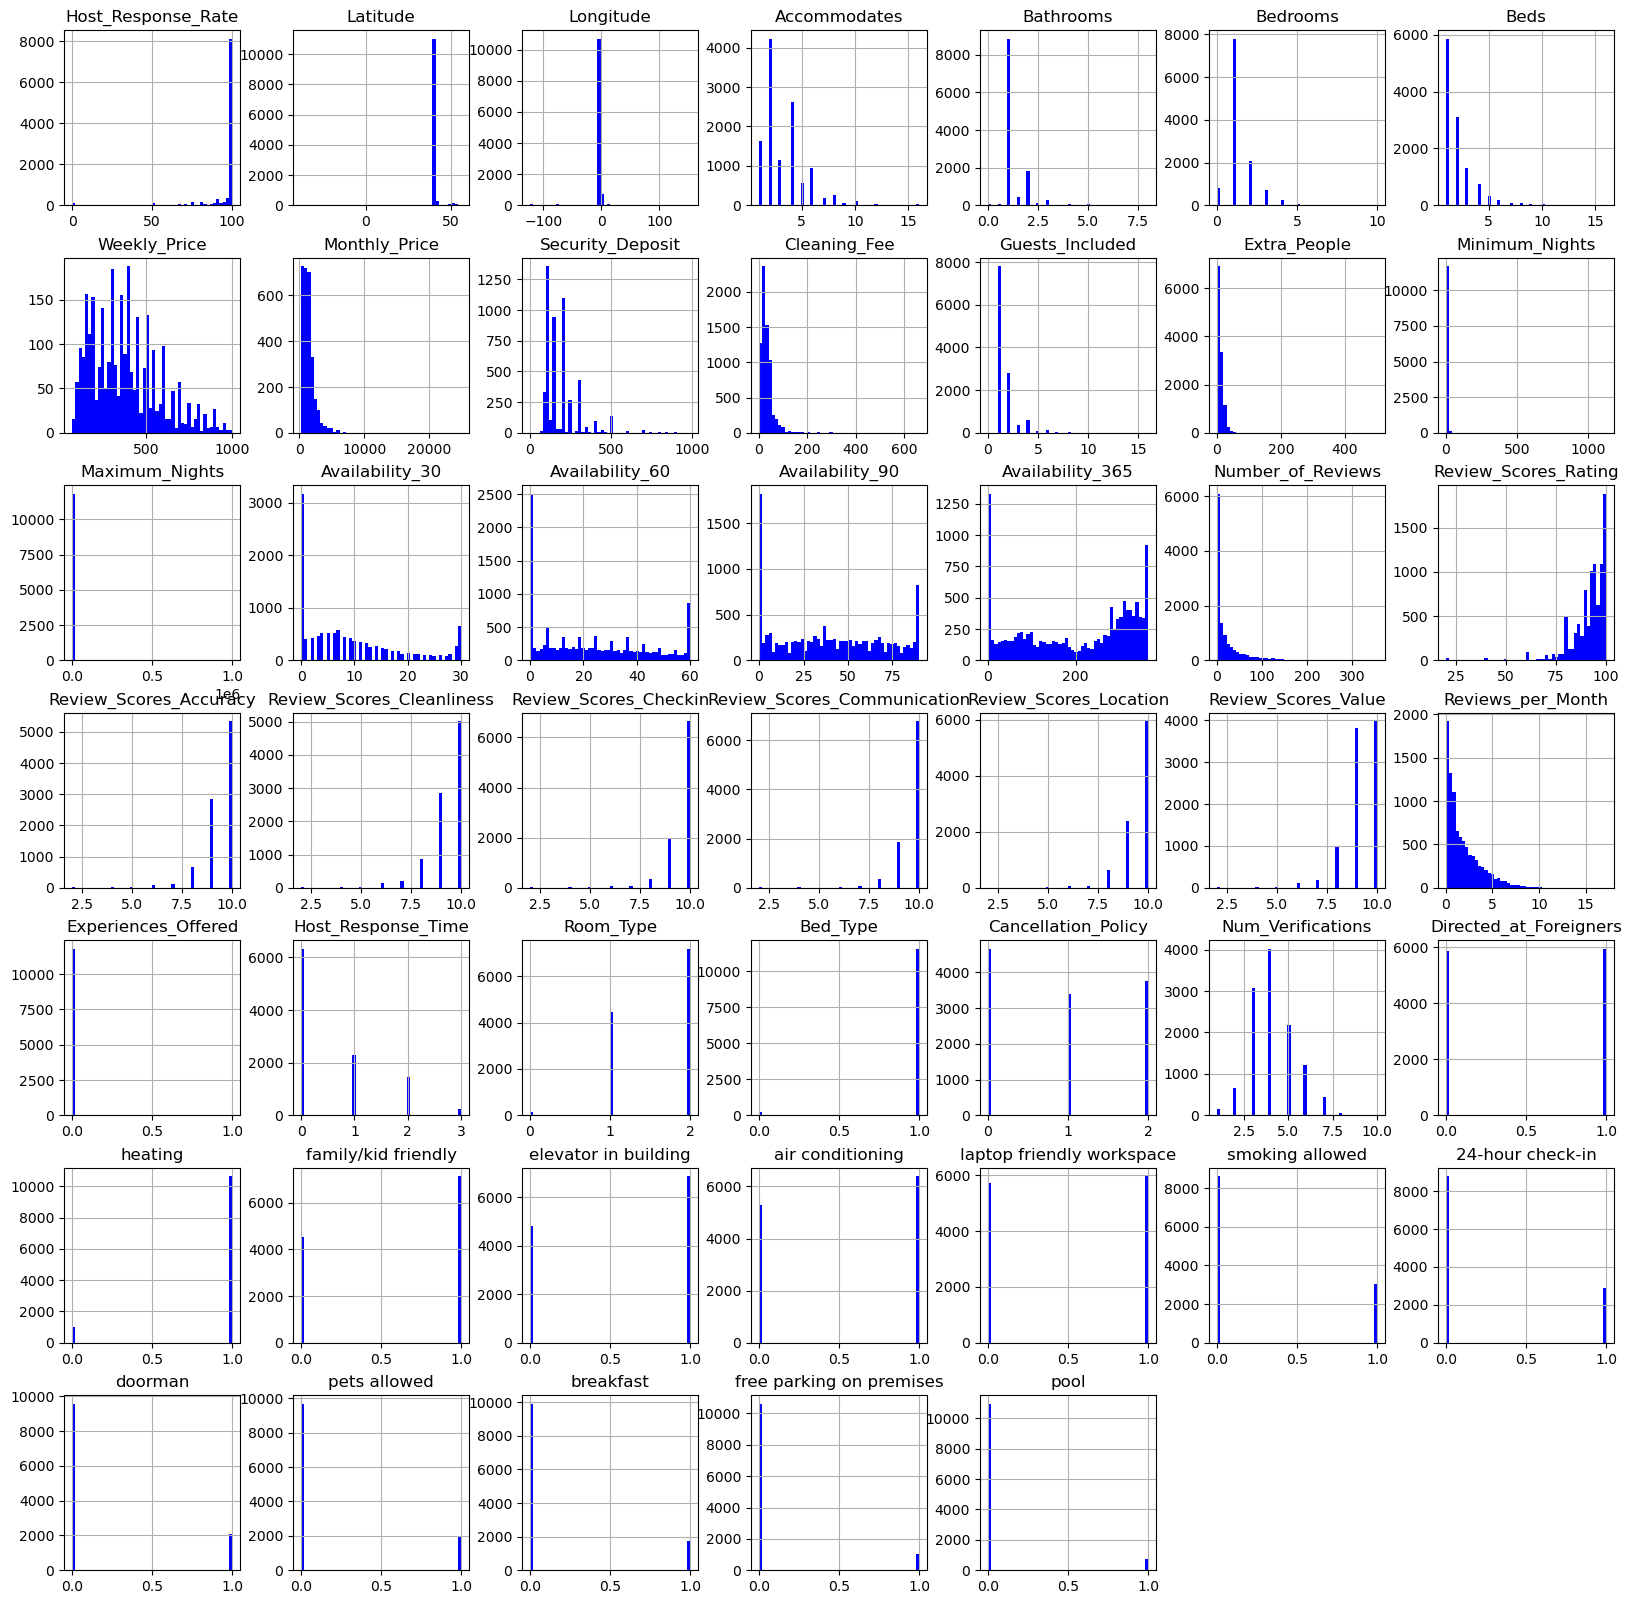

In [254]:
# Plot distributions with histograms
df_numerical.hist(bins=50, figsize=(20,20), color='b')
plt.show()

In [255]:
# For later sanity checks
features_for_imputation = df_numerical.columns
shape_for_imputation = df_numerical.shape

In [256]:
data_to_impute = df_numerical.to_csv('./data_to_impute.csv', sep=';', decimal='.', index=False)

<p style="background-color:#EBF5FB; color:#2471A3;">Median imputation</p>

In [257]:
df_numerical = pd.read_csv('./data_to_impute.csv', sep=';', decimal='.')  

In [258]:
# Impute missing values by Median
imputer = SimpleImputer()
df_imputed = pd.DataFrame(imputer.fit_transform(df_numerical), columns=df_numerical.columns)

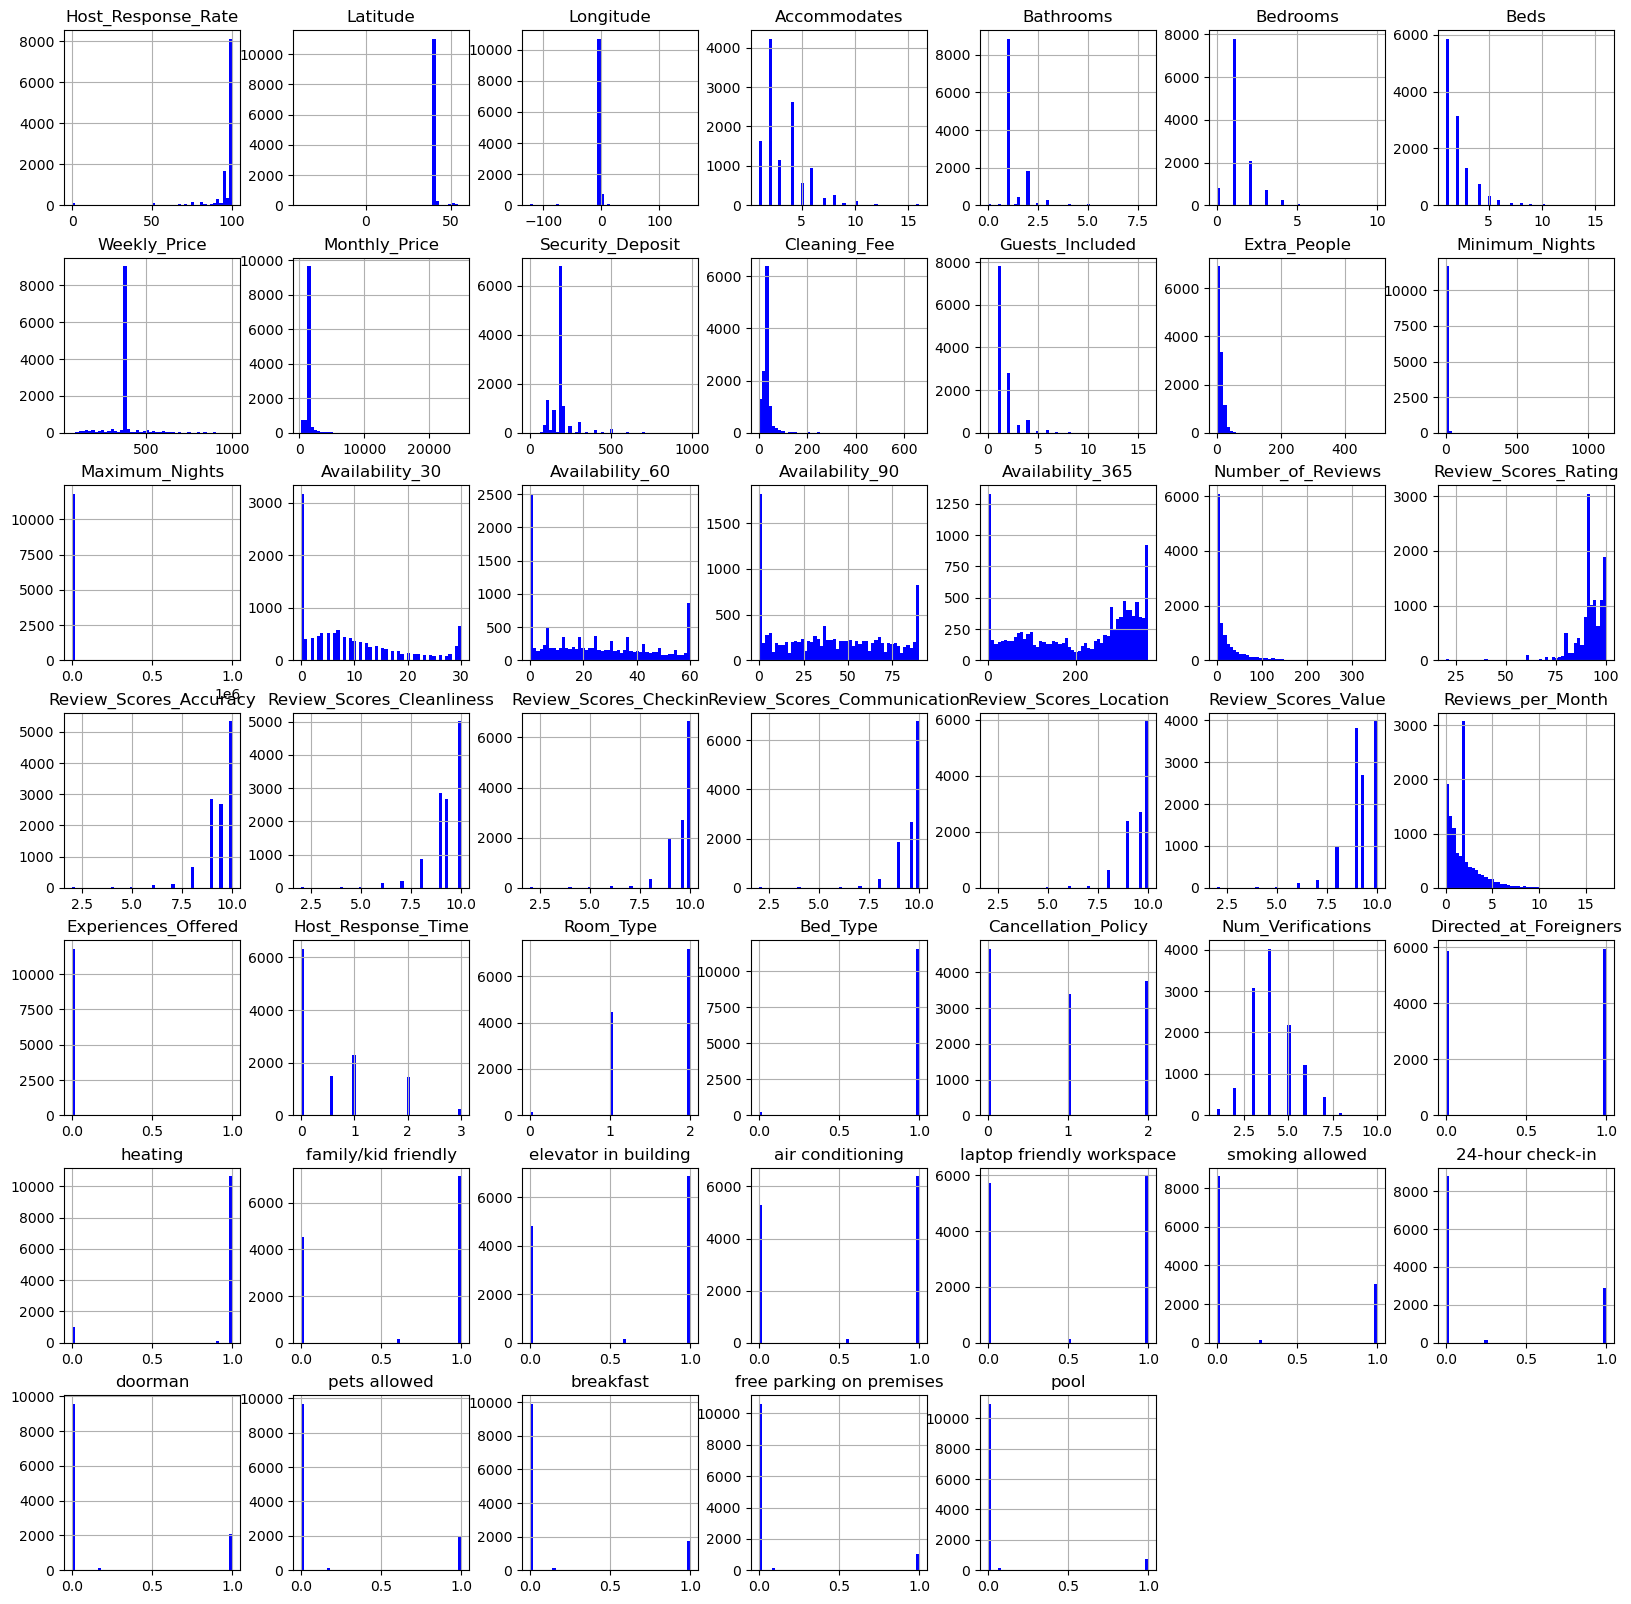

In [259]:
# Show data distribution to check whether the imputation introduced a serious bias
df_imputed.hist(bins=50, figsize=(20,20), color='b')
plt.show()

In [260]:
df_imputed.describe()

Host_Response_Rate      Latitude     Longitude  Accommodates  \
count        11824.000000  11824.000000  11824.000000  11824.000000   
mean            94.803722     40.491628     -3.776863      3.277486   
std             14.242245      4.701030     14.014695      2.093973   
min              0.000000    -37.851182   -123.124429      1.000000   
25%             94.803722     40.409758     -3.707538      2.000000   
50%            100.000000     40.419331     -3.700763      3.000000   
75%            100.000000     40.430778     -3.683917      4.000000   
max            100.000000     55.966912    153.371427     16.000000   

          Bathrooms      Bedrooms          Beds  Weekly_Price  Monthly_Price  \
count  11824.000000  11824.000000  11824.000000  11824.000000   11824.000000   
mean       1.285229      1.344290      2.049122    378.437348    1432.390728   
std        0.663453      0.904414      1.620947     96.119864     609.246366   
min        0.000000      0.000000      1.000000     70.000000     250.000000   
25%        1.000000      1.000000      1.000000    378.437348    1432.390728   
50%        1.000000      1.000000      2.000000    378.437348    1432.390728   
75%        1.000000      2.000000      2.000000    378.437348    1432.390728   
max        8.000000     10.000000     16.000000    999.000000   25000.000000   

       Security_Deposit  Cleaning_Fee  Guests_Included  Extra_People  \
count      11824.000000  11824.000000     11824.000000  11824.000000   
mean         189.312154     32.073129         1.581614      7.637601   
std           75.827585     24.020686         1.160518     12.373491   
min            0.000000      0.000000         0.000000      0.000000   
25%          189.312154     20.000000         1.000000      0.000000   
50%          189.312154     32.073129         1.000000      0.000000   
75%          189.312154     32.073129         2.000000     15.000000   
max          990.000000    662.000000        16.000000    500.000000   

       Minimum_Nights  Maximum_Nights  Availability_30  Availability_60  \
count    11824.000000    11824.000000     11824.000000     11824.000000   
mean         3.109946      961.732070         8.949002        22.949256   
std         13.427477     9387.640642         9.340334        19.762734   
min          1.000000        1.000000         0.000000         0.000000   
25%          1.000000      365.000000         0.000000         4.000000   
50%          2.000000     1125.000000         6.000000        20.000000   
75%          3.000000     1125.000000        14.000000        38.000000   
max       1125.000000  1000000.000000        30.000000        60.000000   

       Availability_90  Availability_365  Number_of_Reviews  \
count     11824.000000      11824.000000       11824.000000   
mean         39.803958        202.217185          22.664834   
std          29.663314        128.006830          38.092338   
min           0.000000          0.000000           0.000000   
25%          11.000000         78.000000           1.000000   
50%          38.000000        240.000000           7.000000   
75%          65.000000        319.000000          27.000000   
max          90.000000        365.000000         356.000000   

       Review_Scores_Rating  Review_Scores_Accuracy  \
count          11824.000000            11824.000000   
mean              91.628179                9.410040   
std                8.043852                0.824832   
min               20.000000                2.000000   
25%               90.000000                9.000000   
50%               91.628179                9.410040   
75%               97.000000               10.000000   
max              100.000000               10.000000   

       Review_Scores_Cleanliness  Review_Scores_Checkin  \
count               11824.000000           11824.000000   
mean                    9.320726               9.623905   
std                     0.883514               0.706762   
min                  

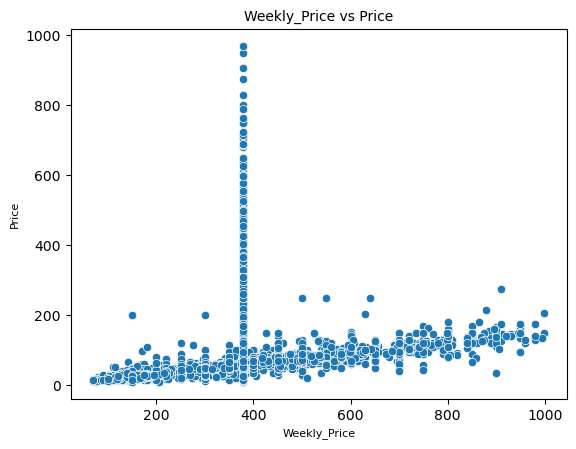

In [261]:
# Visualizing Weekly_Price vs Price
sns.scatterplot(x=df_imputed['Weekly_Price'], y=target)
plt.title('Weekly_Price vs Price', fontsize=10)
plt.xlabel('Weekly_Price', fontsize=8)
plt.ylabel('Price', fontsize=8)
plt.show()

<p style="background-color:#EBF5FB; color:#2471A3;">KNN Imputation</p>

In [262]:
df_numerical = pd.read_csv('./data_to_impute.csv', sep=';', decimal='.') 

In [263]:
df_numerical.shape

(11824, 47)

In [264]:
# Scale data before applying KNN Imputer
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)


In [265]:
# Impute missing values with KNN Imputer
imputer = KNNImputer()
df_scaled_imputed = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df_scaled.columns)

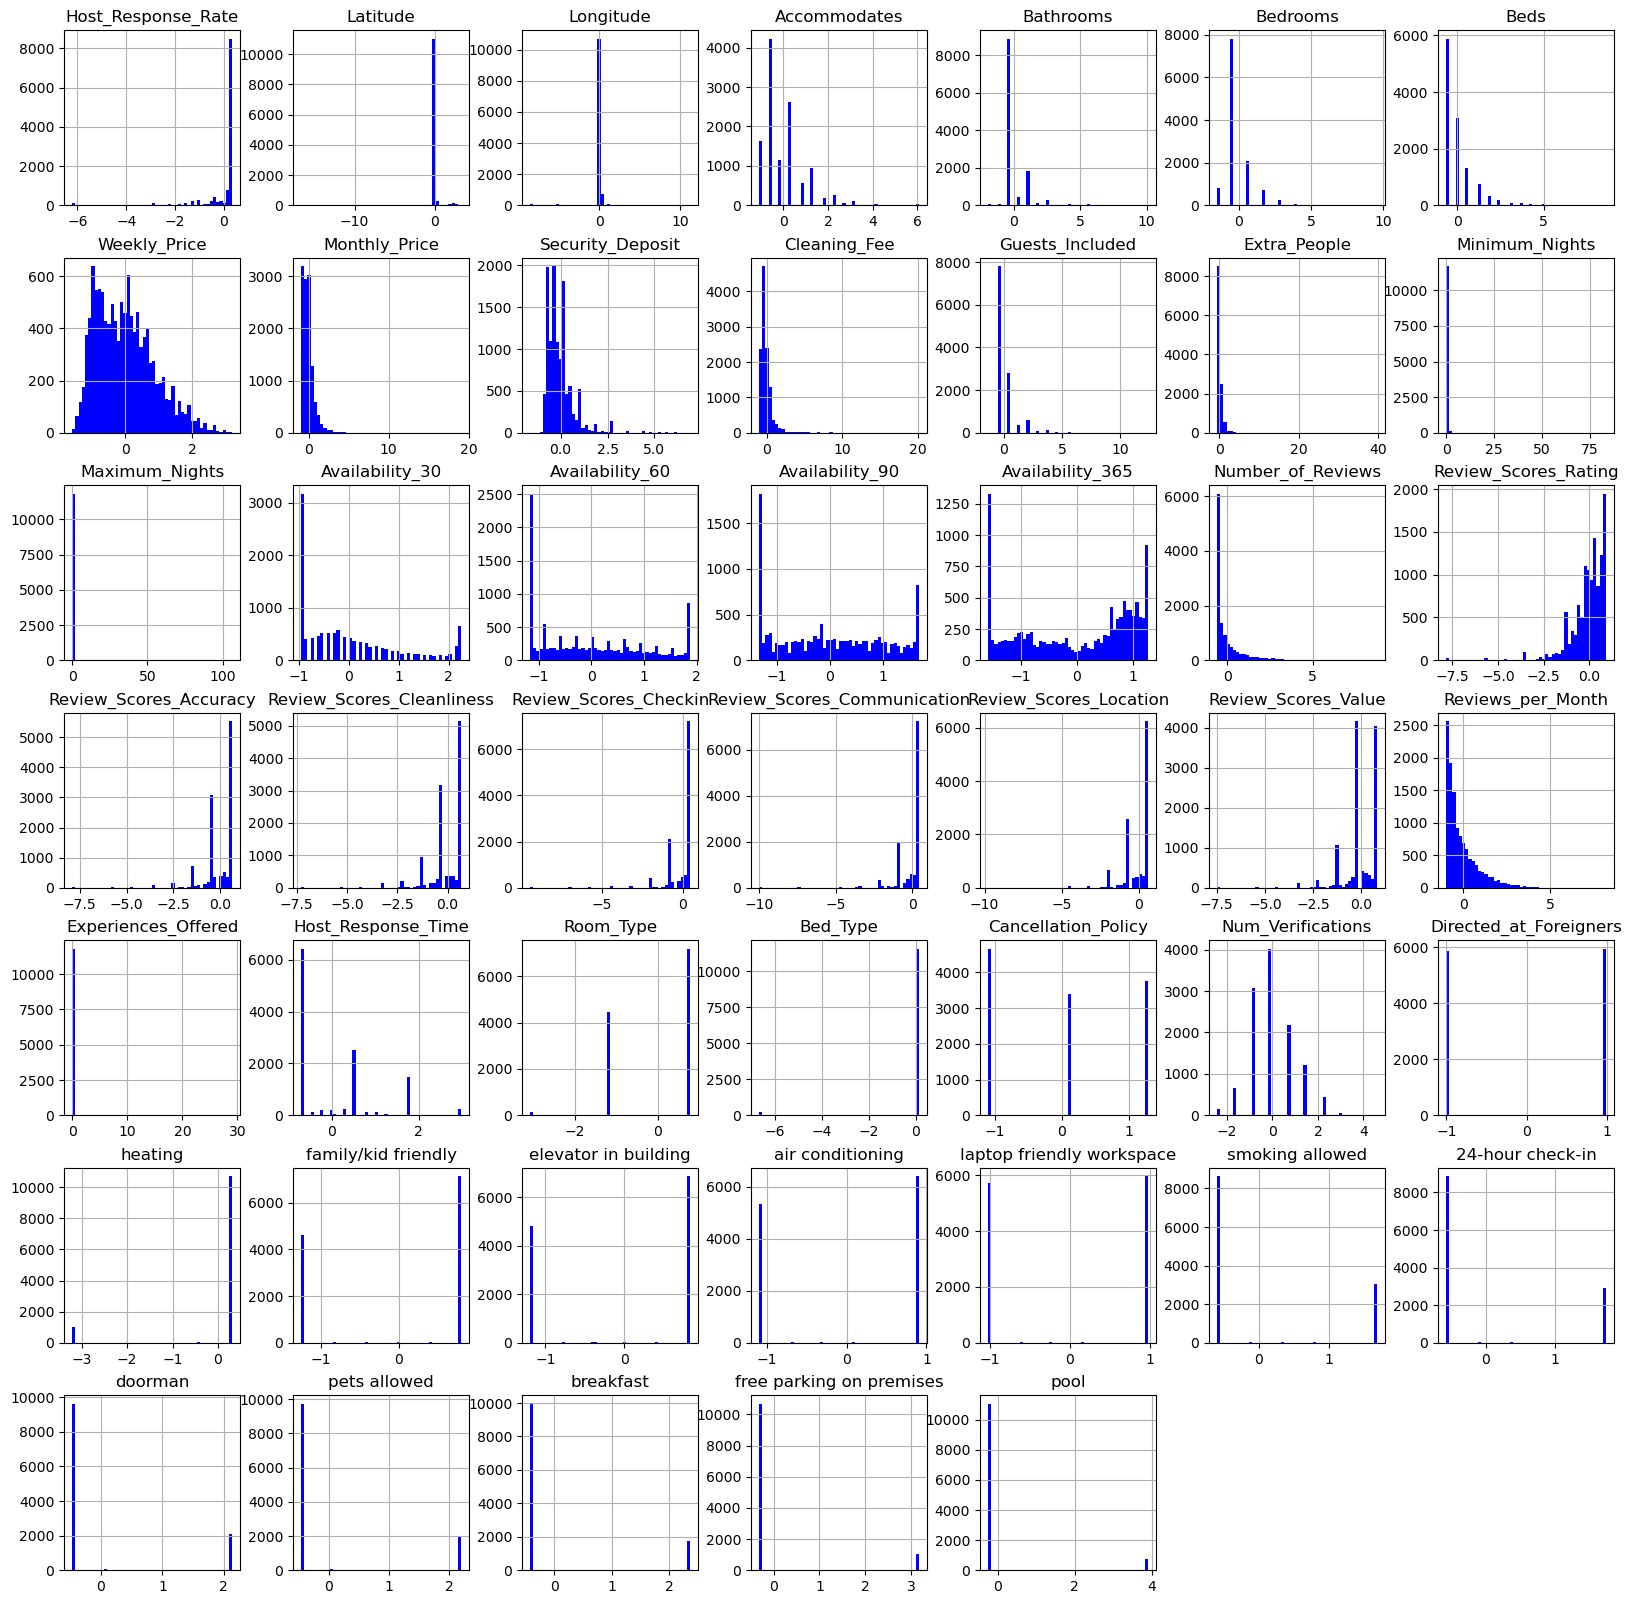

In [266]:
# Show data distribution to check whether the imputation introduced a serious bias
df_scaled_imputed.hist(bins=50, figsize=(20,20), color='b')
plt.show()

In [267]:
# Re-check data normality for any biases after imputation
df_scaled_imputed.describe()

Host_Response_Rate      Latitude     Longitude  Accommodates  \
count        11824.000000  1.182400e+04  1.182400e+04  1.182400e+04   
mean            -0.033595  2.532931e-16  2.403730e-18 -2.674150e-17   
std              0.979777  1.000042e+00  1.000042e+00  1.000042e+00   
min             -6.218130 -1.666573e+01 -8.516248e+00 -1.087685e+00   
25%              0.144053 -1.741608e-02  4.946801e-03 -6.101037e-01   
50%              0.340821 -1.537955e-02  5.430227e-03 -1.325224e-01   
75%              0.340821 -1.294441e-02  6.632326e-03  3.450590e-01   
max              0.340821  3.292031e+00  1.121358e+01  6.076035e+00   

          Bathrooms      Bedrooms          Beds  Weekly_Price  Monthly_Price  \
count  11824.000000  11824.000000  11824.000000  11824.000000   11824.000000   
mean      -0.000668     -0.000513     -0.000855     -0.009225      -0.063955   
std        0.998447      0.999618      0.999145      0.855566       0.761143   
min       -1.933656     -1.485170     -0.646242     -1.584023      -0.956026   
25%       -0.429134     -0.380371     -0.646242     -0.716357      -0.585708   
50%       -0.429134     -0.380371     -0.030258     -0.094688      -0.187900   
75%       -0.429134      0.724428     -0.030258      0.531861       0.186622   
max       10.102521      9.562820      8.593510      3.186987      19.055661   

       Security_Deposit  Cleaning_Fee  Guests_Included  Extra_People  \
count      11824.000000  11824.000000     1.182400e+04  1.182400e+04   
mean          -0.050343     -0.080556     1.186842e-16  1.382145e-17   
std            0.766442      0.936049     1.000042e+00  1.000042e+00   
min           -1.631996     -1.025494    -1.362909e+00 -6.172813e-01   
25%           -0.533724     -0.545890    -5.011885e-01 -6.172813e-01   
50%           -0.218208     -0.296495    -5.011885e-01 -6.172813e-01   
75%            0.092136      0.029635     3.605321e-01  5.950390e-01   
max            6.902459     20.141038     1.242462e+01  3.979339e+01   

       Minimum_Nights  Maximum_Nights  Availability_30  Availability_60  \
count    1.182400e+04    1.182400e+04     1.182400e+04     1.182400e+04   
mean    -1.081679e-17    2.403730e-18     4.386808e-17     1.171819e-17   
std      1.000042e+00    1.000042e+00     1.000042e+00     1.000042e+00   
min     -1.571431e-01   -1.023444e-01    -9.581435e-01    -1.161288e+00   
25%     -1.571431e-01   -6.356840e-02    -9.581435e-01    -9.588783e-01   
50%     -8.266578e-02    1.739253e-02    -3.157410e-01    -1.492395e-01   
75%     -8.188472e-03    1.739253e-02     5.407956e-01     7.616042e-01   
max      8.355535e+01    1.064251e+02     2.253869e+00     1.874858e+00   

       Availability_90  Availability_365  Number_of_Reviews  \
count     1.182400e+04      1.182400e+04       1.182400e+04   
mean     -1.317545e-16      1.045623e-16      -2.043171e-17   
std       1.000042e+00      1.000042e+00       1.000042e+00   
min      -1.341915e+00     -1.579804e+00      -5.950224e-01   
25%      -9.710708e-01     -9.704360e-01      -5.687693e-01   
50%      -6.081702e-02      2.951750e-01      -4.112506e-01   
75%       8.494367e-01      9.123556e-01       1.138116e-01   
max       1.692264e+00      1.271727e+00       8.751084e+00   

       Review_Scores_Rating  Review_Scores_Accuracy  \
count          11824.000000            11824.000000   
mean              -0.048853               -0.045635   
std                0.945839                0.943197   
min               -7.839255               -7.900152   
25%               -0.397081               -0.437161   
50%                0.150137                0.202524   
75%                0.587912                0.628980   
max                0.916243                0.628980   

       Review_Scores_Cleanliness  Review_Scores_Checkin  \
count               11824.000000           11824.000000   
mean                   -0.063746              -0.049824   
std                     0.944970               0.954846   
min                  

<p style="background-color:#FDEBD0;"><b>Observations: </b>Imputation by Median introduces significant changes to how, for example, 'Weekly_Price' is distributed relative to its counts and to the target variable. The distributions after KNN Imputation remain similar.</p>

<p style="background-color:#EBF5FB; color:#2471A3;">--------------------------------------------------------------------------------------------------------------------------------------------</p>

<h3 style="background-color:#EBF5FB; color:#2471A3;">Conforming to statistical assumptions</h3>

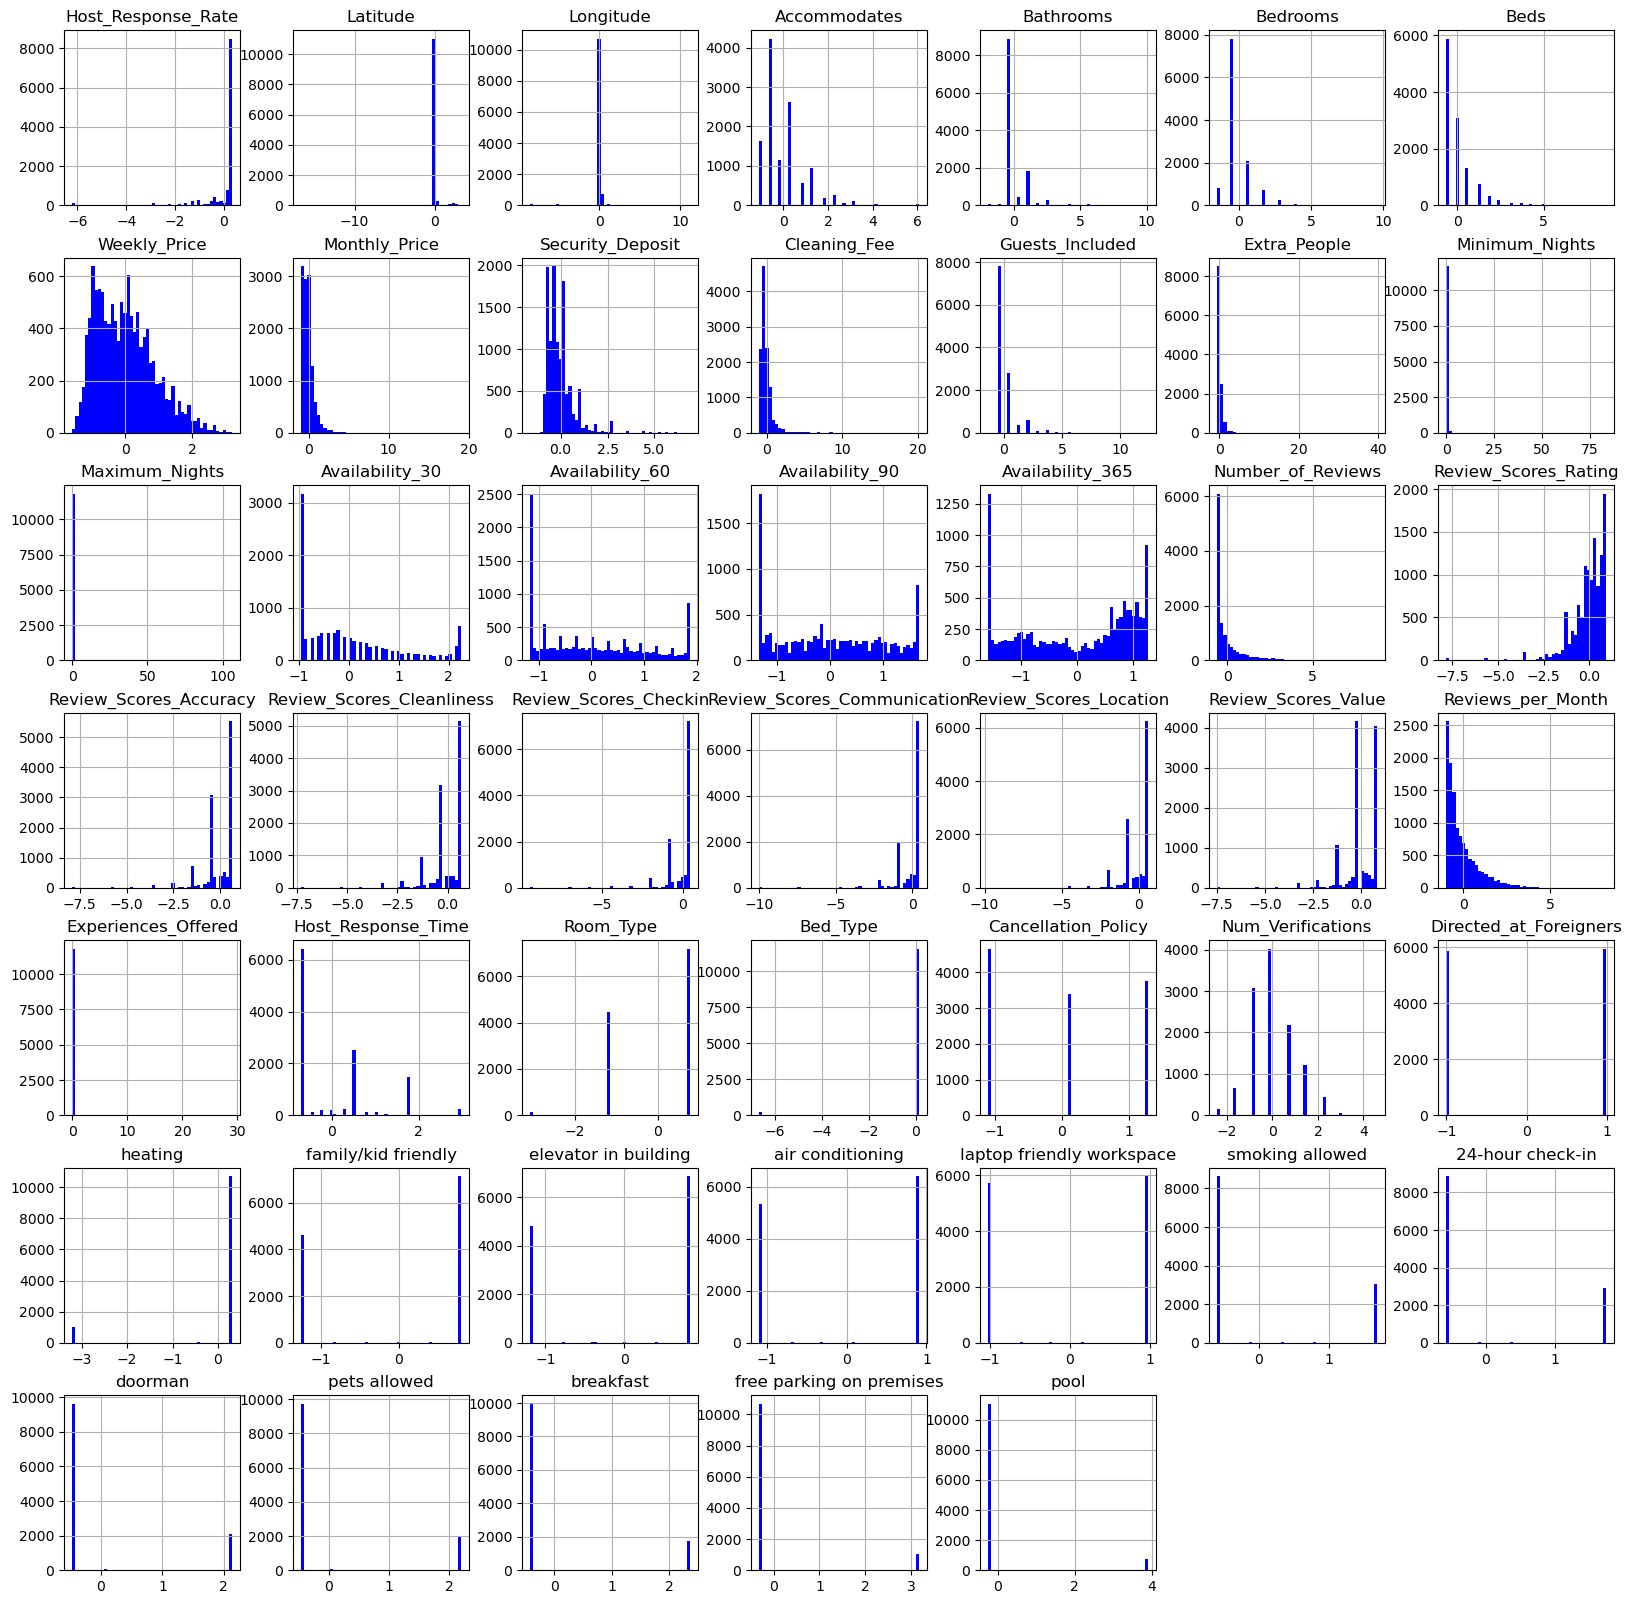

In [268]:
df_scaled_imputed.hist(bins=50, figsize=(20,20), color='b')
plt.show()

In [269]:
# Apply transformations to normalize distributions

# Check for zero values
variables = ['Weekly_Price', 'Monthly_Price', 'Security_Deposit', 'Cleaning_Fee', 'Beds', 
             'Guests_Included', 'Number_of_Reviews', 'Reviews_per_Month']

for var in variables:
    print(var, (df_scaled_imputed[var] == 0.0).any())

Weekly_Price False
Monthly_Price False
Security_Deposit False
Cleaning_Fee False
Beds False
Guests_Included False
Number_of_Reviews False
Reviews_per_Month False


In [270]:
# Right skewed data (square root transformation for moderately skewed, log transformation for highly skewed data without zero)

df_scaled_imputed['sqrt_Weekly_Price'] = np.sqrt(df_scaled_imputed['Weekly_Price']) 
df_scaled_imputed['sqrt_Security_Deposit'] = np.sqrt(df_scaled_imputed['Security_Deposit'])
df_scaled_imputed['sqrt_Monthly_Price'] = np.sqrt(df_scaled_imputed['Monthly_Price'])
df_scaled_imputed['sqrt_Cleaning_Fee'] = np.sqrt(df_scaled_imputed['Cleaning_Fee'])
df_scaled_imputed['sqrt_Number_of_Reviews'] = np.sqrt(df_scaled_imputed['Number_of_Reviews'])
df_scaled_imputed['sqrt_Beds'] = np.sqrt(df_scaled_imputed['Beds'])
df_scaled_imputed['sqrt_Reviews_per_Month'] = np.sqrt(df_scaled_imputed['Reviews_per_Month'])

/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/panda

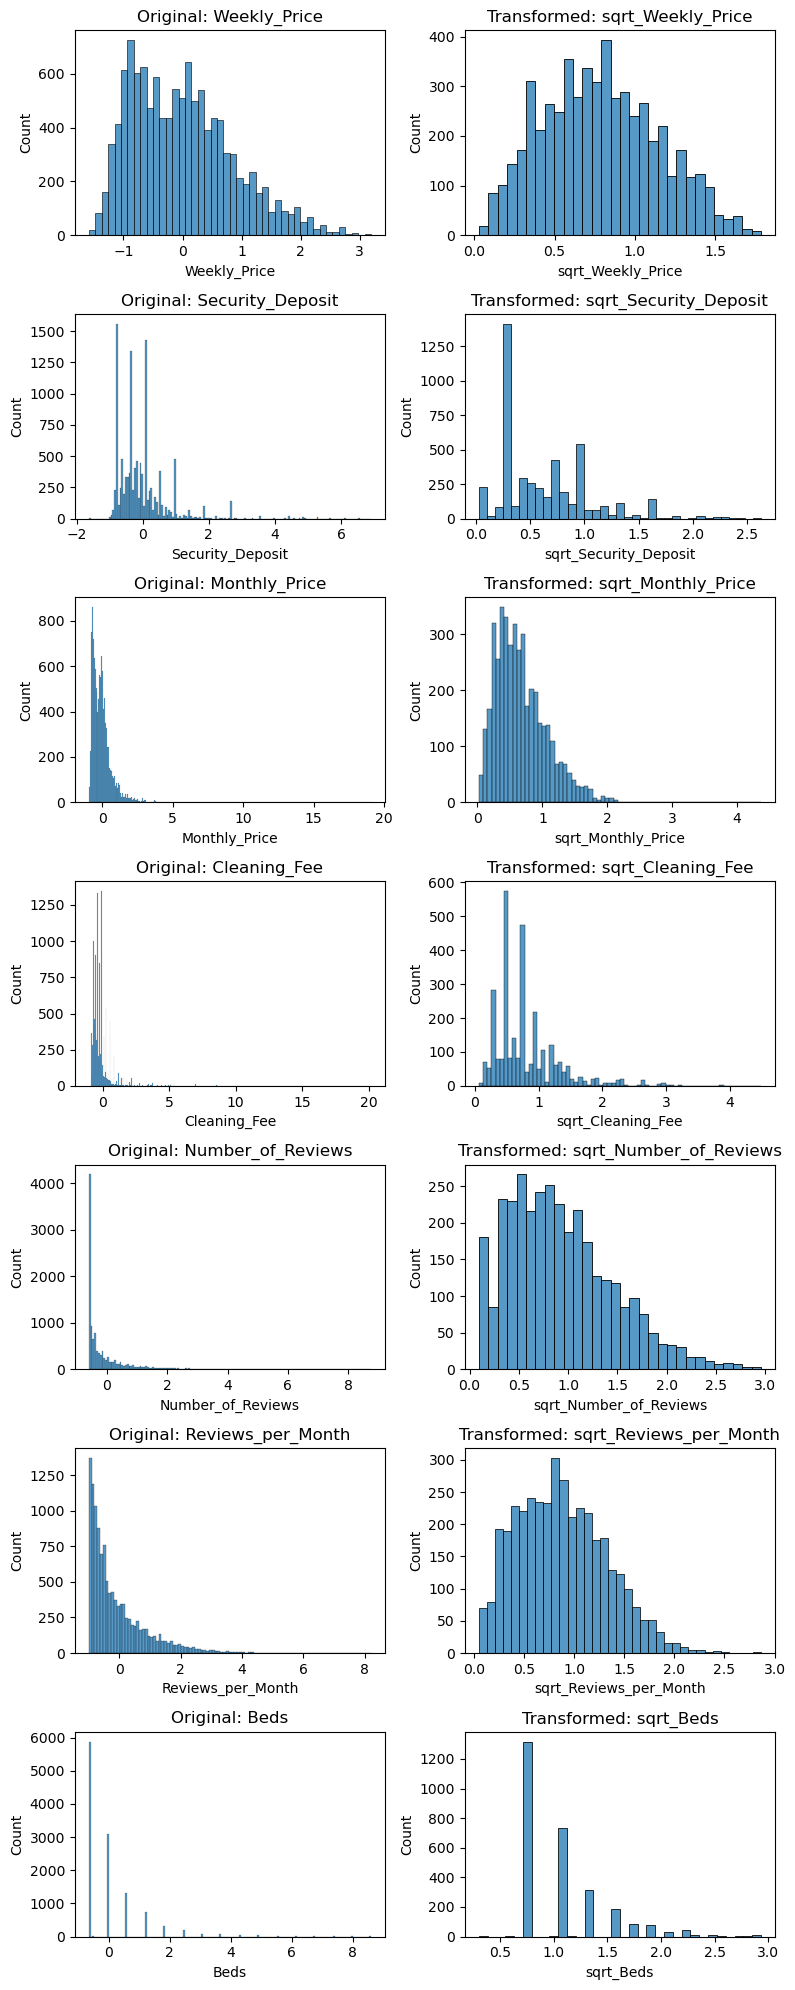

In [271]:
# Plot histograms for original and transformed data side by side
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(8, 20))

original_columns = ['Weekly_Price', 'Security_Deposit', 'Monthly_Price', 'Cleaning_Fee', 'Number_of_Reviews', 'Reviews_per_Month','Beds', 'Guests_Included']
transformed_columns = ['sqrt_Weekly_Price', 'sqrt_Security_Deposit', 'sqrt_Monthly_Price', 'sqrt_Cleaning_Fee', 'sqrt_Number_of_Reviews', 'sqrt_Reviews_per_Month','sqrt_Beds']


for i, (original, transformed) in enumerate(zip(original_columns, transformed_columns)):

    sns.histplot(df_scaled_imputed[original], ax=axes[i, 0])
    axes[i, 0].set_title(f'Original: {original}')

    sns.histplot(df_scaled_imputed[transformed], ax=axes[i, 1])
    axes[i, 1].set_title(f'Transformed: {transformed}')

plt.tight_layout()
plt.show()

<p style="background-color:#FDEBD0;"><b>Observations: </b>The discrete features maintain the same distribution after transformation. I will keep the discrete features without transformations.</p>

In [272]:
df_scaled_imputed.drop(['sqrt_Beds','Reviews_per_Month', 'Weekly_Price', 'Monthly_Price', 'Security_Deposit', 'Cleaning_Fee', 'Number_of_Reviews'], axis=1, inplace=True)

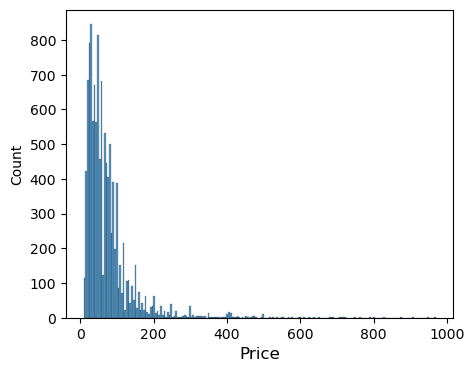

In [273]:
# Check the distrinution of the target variable
plt.figure(figsize=(5, 4))
sns.histplot(target)
plt.xlabel('Price', fontsize=12)
plt.show()

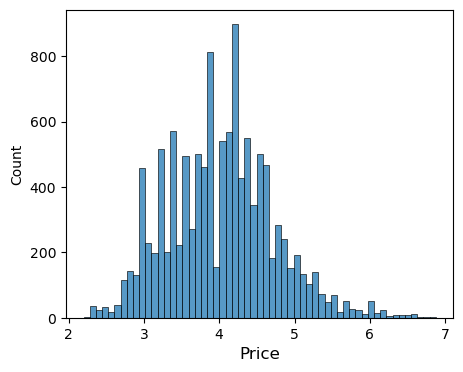

In [274]:
# Transforming Price
log_target = np.log(target) 

plt.figure(figsize=(5, 4))
sns.histplot(log_target)
plt.xlabel('Price', fontsize=12)
plt.show()

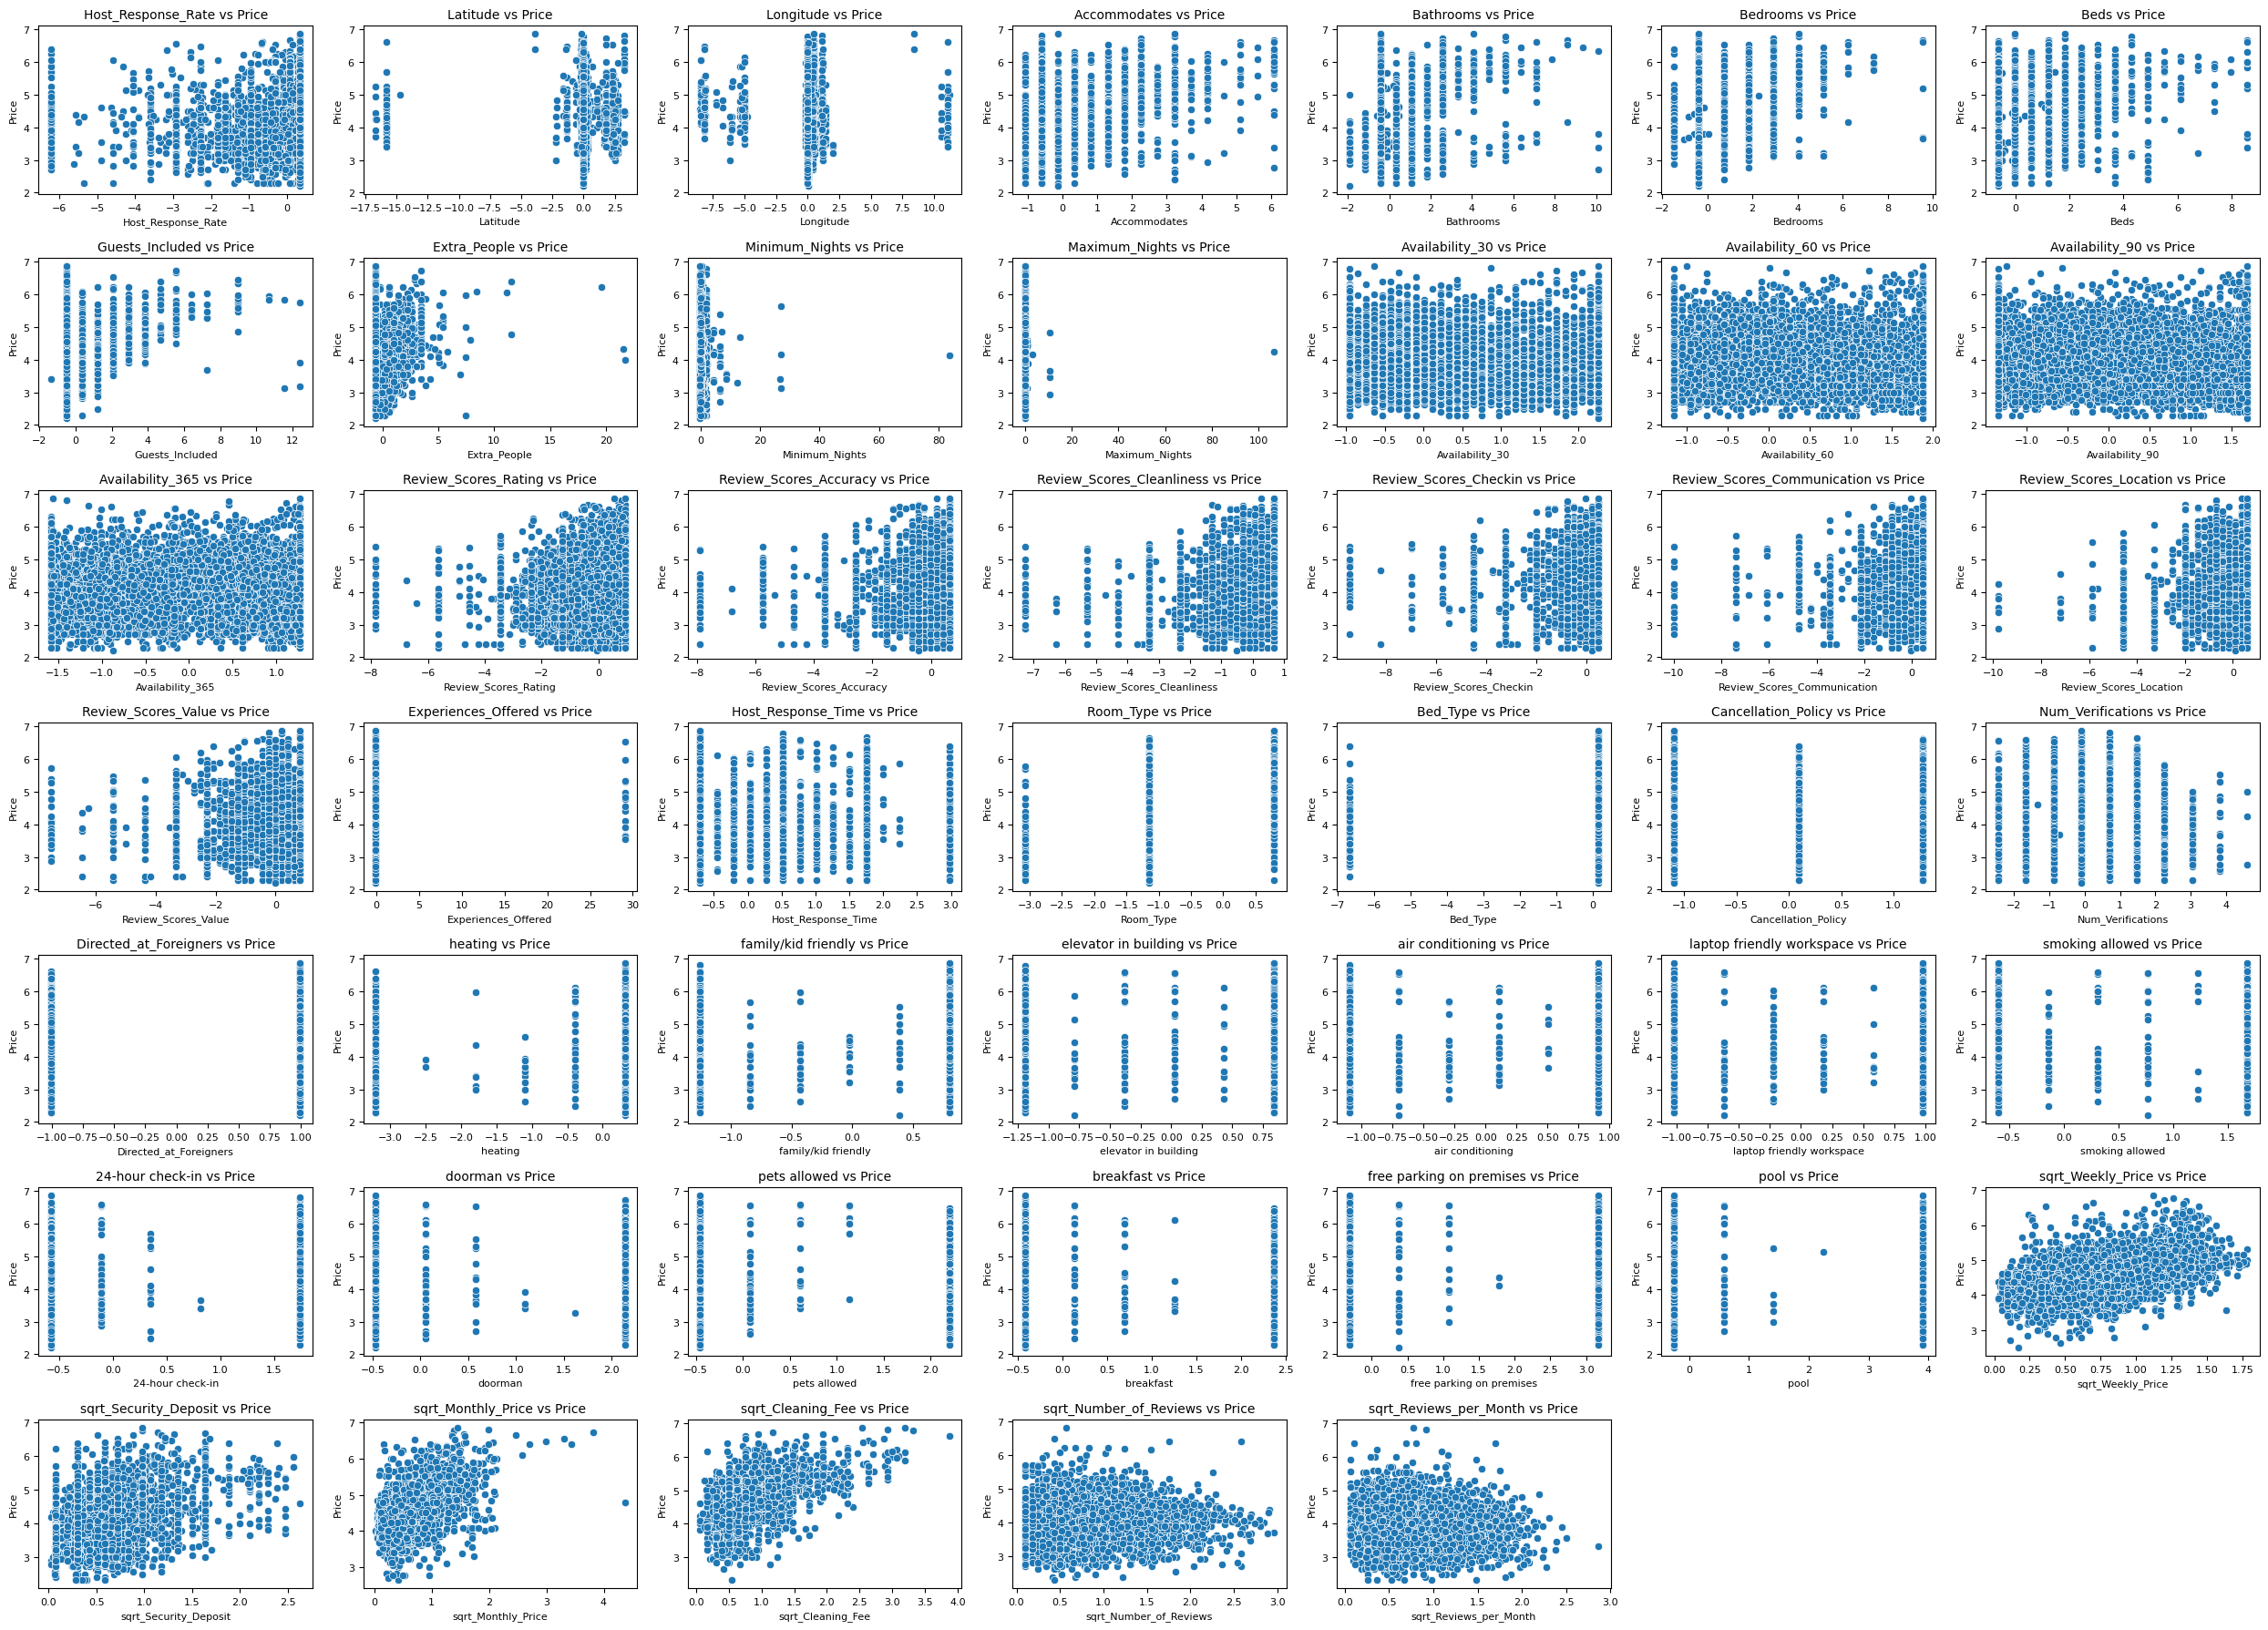

In [275]:
# Visualizing Price vs. individual features

features = df_scaled_imputed.columns

n_cols = 7
n_rows = (len(features) + n_cols - 1) // n_cols  

# Create the subplots grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 18))  

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.scatterplot(x=df_scaled_imputed[feature], y=log_target, ax=axes[i])
    axes[i].set_title(f'{feature} vs Price', fontsize=10)
    axes[i].set_xlabel(feature, fontsize=8)
    axes[i].set_ylabel('Price', fontsize=8)
    axes[i].tick_params(axis='both', which='major', labelsize=8)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [276]:
df_scaled_imputed.shape

(11824, 47)

In [277]:
# Elimination of outliers

# Concatenate with target feature
full_df = pd.concat([df_scaled_imputed, target], axis=1)

full_df = full_df[full_df['Minimum_Nights'] <= 80]
full_df = full_df[full_df['Maximum_Nights'] < 100]
full_df = full_df[full_df['Extra_People'] <= 17]

In [278]:
full_df.shape

(11817, 48)

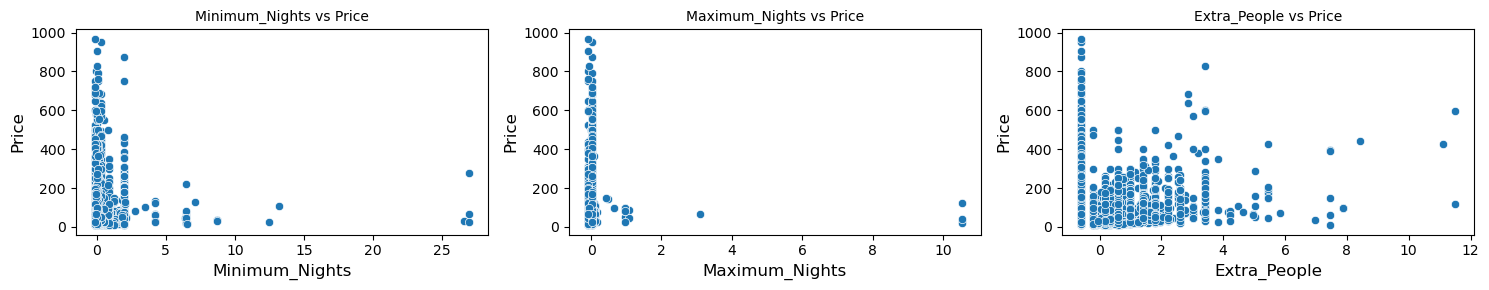

In [279]:
# Plot scatterplots without outliers
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

columns = ['Minimum_Nights', 'Maximum_Nights', 'Extra_People']

axes = axes.flatten()

for i, feature in enumerate(columns):
    sns.scatterplot(x=full_df[feature], y=full_df['Price'], ax=axes[i])
    axes[i].set_title(f'{feature} vs Price', fontsize=10)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Price', fontsize=12)

# Hide any unused axes if there are fewer features than subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [280]:
full_df.shape

(11817, 48)

<p style="background-color:#EBF5FB; color:#2471A3;">--------------------------------------------------------------------------------------------------------------------------------------------</p>

<h3 style="background-color:#EBF5FB; color:#2471A3;">Exploring correlations between features</h3>

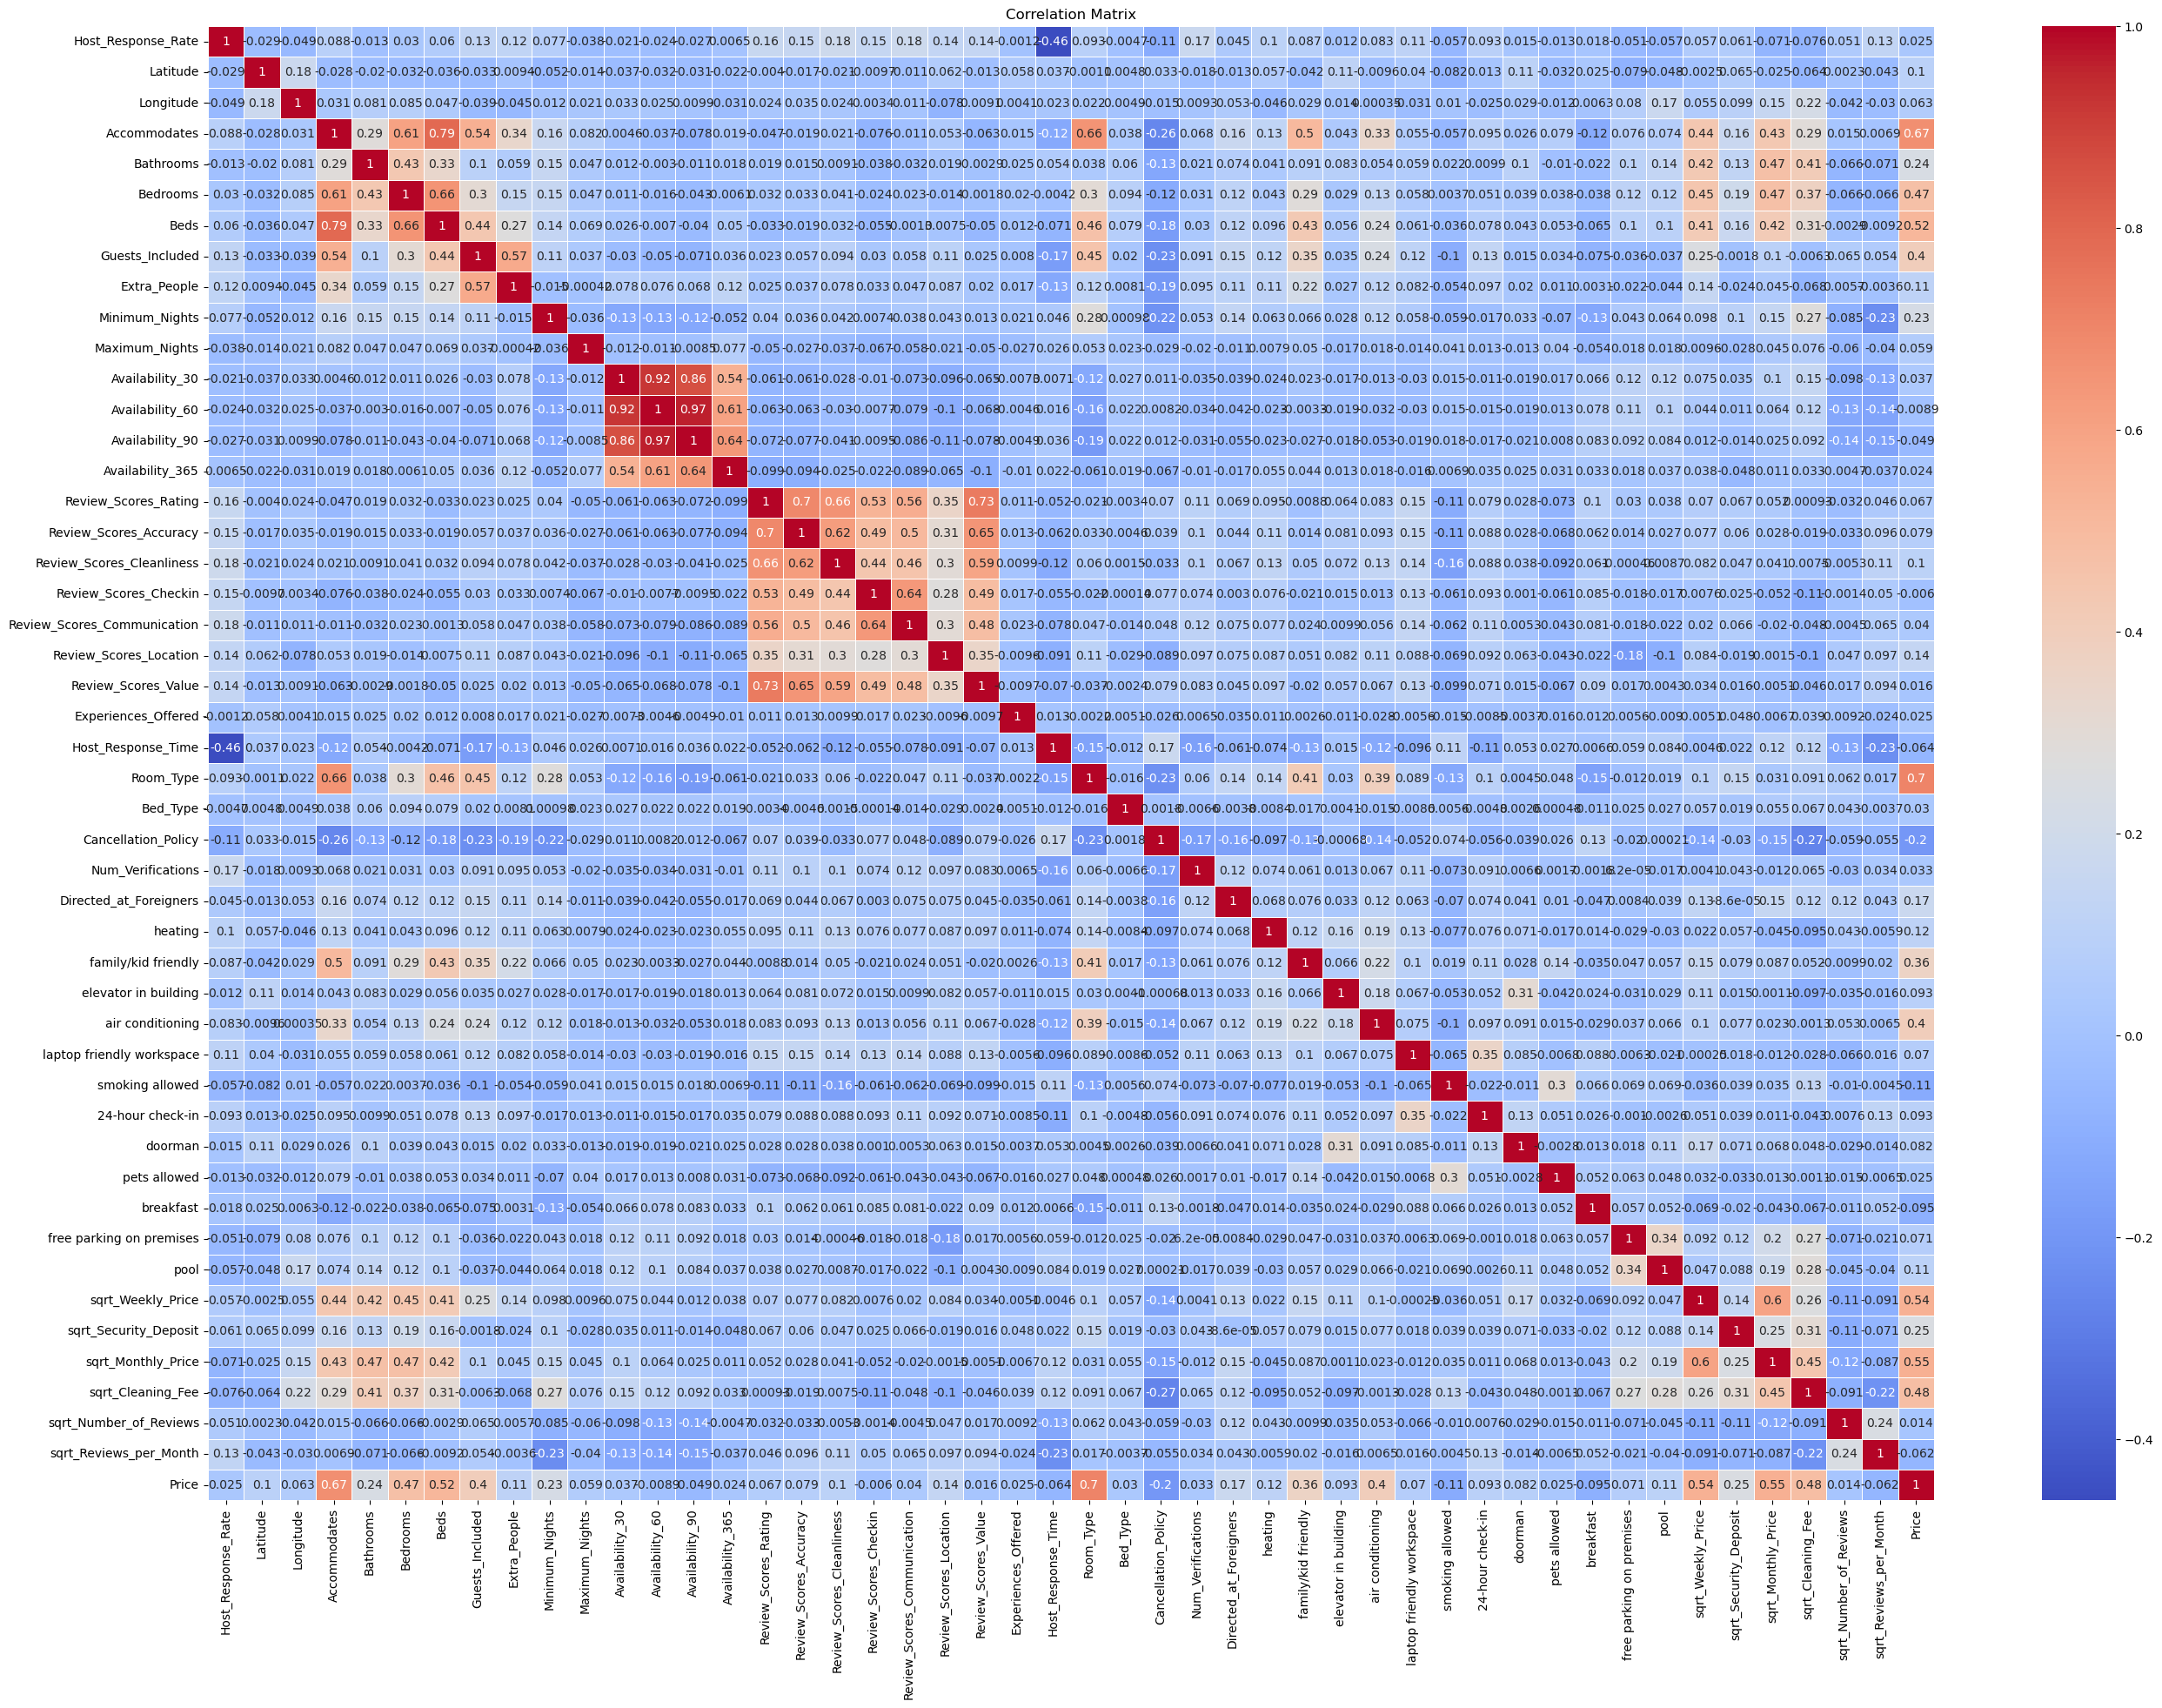

In [281]:
correlation_matrix = full_df.corr(method='spearman')

# Plot the correlation coefficients
plt.figure(figsize=(32, 22))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<p style="background-color:#FDEBD0;"><b>Observations: </b>Availability_30, Availability_60, Availability_90 are highly correlated and almost identical. Due to redundancy, I will keep only Availability_90 given it has higher correlation to Price than the rest of the two features.</p>
<p style="background-color:#FDEBD0;">There is a high correlation between different Review Scores. I will keep the feature in for now, but may consider to reduced them (e.g., averaging) based on model performance.</p>

In [282]:
full_df.drop(['Availability_30', 'Availability_60'], axis=1, inplace=True)

In [283]:
final_set_of_features = full_df.columns

<h1 style="background-color:#EBF5FB; color:#2471A3;">Automatic feature selection</h1>

In [284]:
# Check number of null values
full_df.Price.isnull().sum()

13

In [285]:
# Check number of null values in Price before removal
percent_removed = ((len(full_df) - len(full_df[~full_df['Price'].isnull()])) / len(full_df)) * 100
print(f"\nPercentage of rows to be removed: {percent_removed:.2f}%")

# Remove rows where Price is missing
full_df = full_df[~full_df['Price'].isnull()]
print("\nNumber of null values in Price after:", full_df['Price'].isnull().sum())
print("Total rows after:", len(full_df))


Percentage of rows to be removed: 0.11%

Number of null values in Price after: 0
Total rows after: 11804


In [286]:
X_train = full_df.drop(['Price'], axis=1)
y_train = full_df['Price']

print(X_train.shape, y_train.shape)

(11804, 45) (11804,)


In [287]:
feature_names = X_train.columns

In [288]:
# Transform to arrays
X_train = X_train.values
y_train = full_df['Price'].values

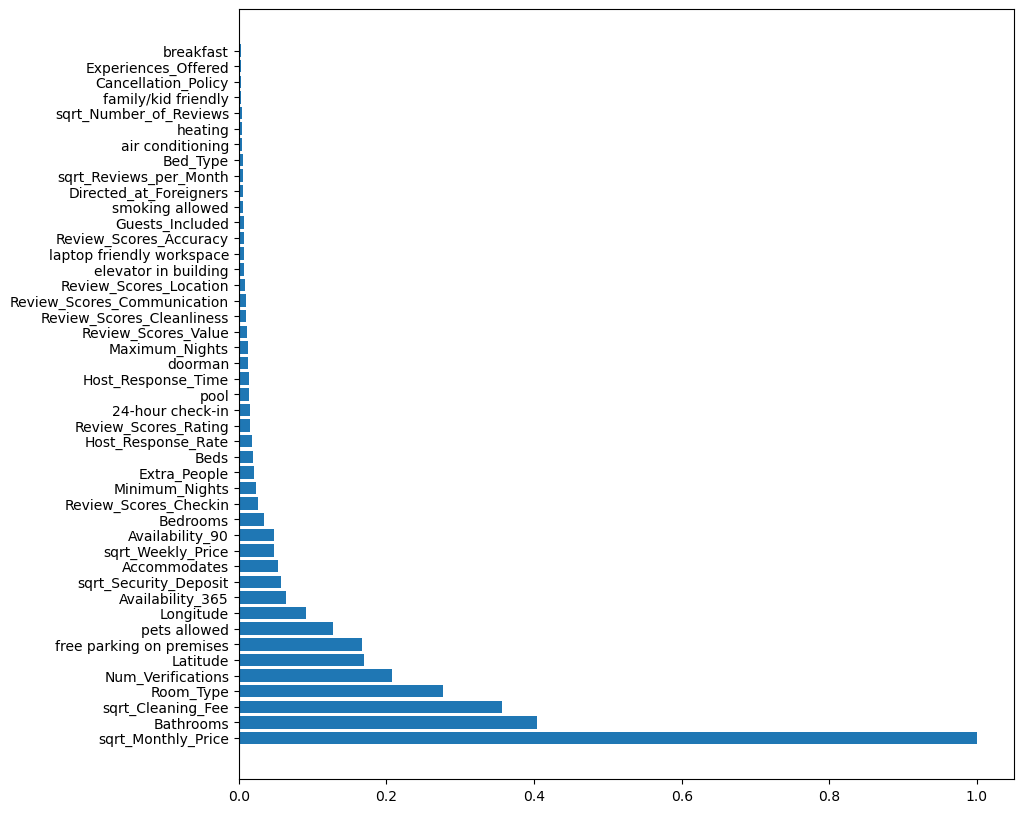

In [289]:
# Run a Random Forest regressor to get feature importances
rf = RandomForestRegressor(random_state=0, n_estimators=200, max_depth=8).fit(X_train, y_train)

importances = rf.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

In [290]:
from sklearn.model_selection import KFold

N,Nfeatures = X_train.shape

rf = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=5)
kf  = KFold(n_splits=10, shuffle = True, random_state=1)
cv_error = []
cv_std = []

for nfeatures in range(Nfeatures,0,-1):
        
    error_i = []
    
    for idxTrain, idxVal in kf.split(X_train):
        
        Xt = X_train[idxTrain,:]
        yt = y_train[idxTrain]
        Xv = X_train[idxVal,:]
        yv = y_train[idxVal]
        
        rf.fit(Xt,yt)
        
        ranking = rf.feature_importances_
        indices = np.argsort(ranking)[::-1] 
    
        selected = indices[0:(Nfeatures-nfeatures+1)]
        
        Xs = Xt[:,selected]
        
        rf.fit(Xs,yt)
        error = (1.0-rf.score(Xv[:,selected],yv))     
        error_i.append(error) 
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))
    
    print('# features ' + str(len(selected)) + ' error ' + str(np.mean(error_i)) + ' +/- ' + str(np.std(error_i)))

# features 1 error 0.6734268770447137 +/- 0.06562147888227055
# features 2 error 0.6053725398591668 +/- 0.0690183653541328
# features 3 error 0.5575710790341036 +/- 0.06488010378104739
# features 4 error 0.5391959490113998 +/- 0.06893827600691713
# features 5 error 0.4837550498683155 +/- 0.06264444926402032
# features 6 error 0.4321810878823368 +/- 0.0632966518285862
# features 7 error 0.43146462984484446 +/- 0.06615859181122324
# features 8 error 0.4234431351749911 +/- 0.06666100773600189
# features 9 error 0.4234480167922137 +/- 0.06435136287672268
# features 10 error 0.42170952492182356 +/- 0.063056164559607
# features 11 error 0.4211071759577457 +/- 0.0621102681918368
# features 12 error 0.4224002691013576 +/- 0.06312571507850169
# features 13 error 0.42278720784144336 +/- 0.06313494259793091
# features 14 error 0.42212001885621797 +/- 0.06117720431074435
# features 15 error 0.42103637782142184 +/- 0.06237254539198185
# features 16 error 0.42271910186662076 +/- 0.06167258724163525


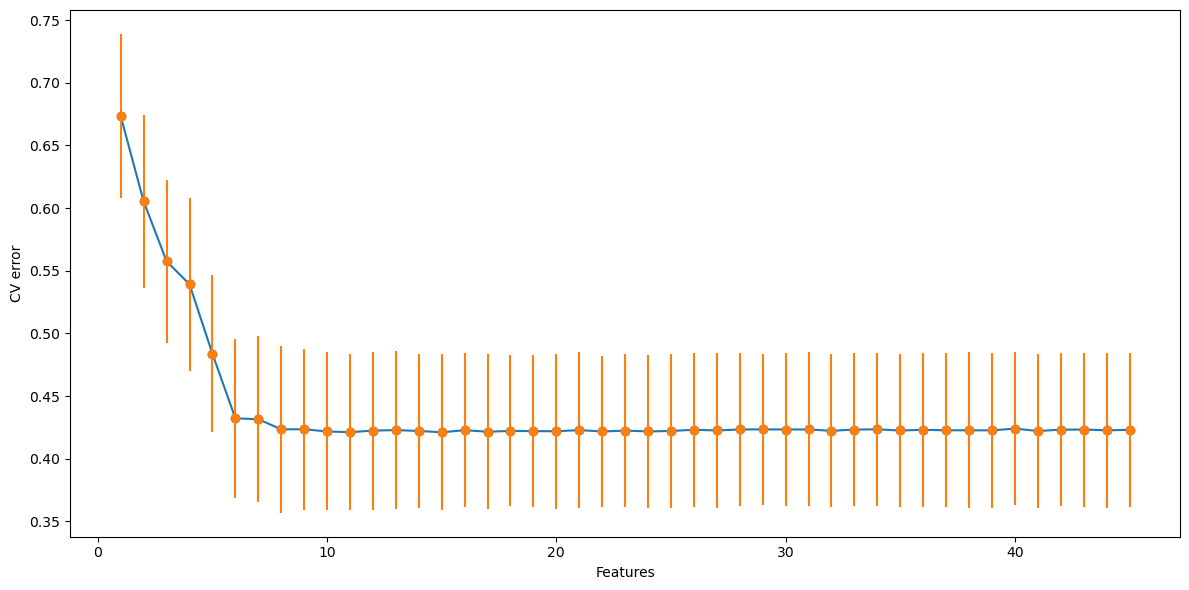

In [291]:
# Plor CV error per number of features in the model
plt.figure(figsize=(12,6))
plt.plot(range(1,Nfeatures+1,1),cv_error,'-o')
plt.errorbar(range(1,Nfeatures+1,1), cv_error, yerr=cv_std, fmt='o')
plt.xlabel('Features')
plt.ylabel('CV error')
plt.tight_layout()
plt.show()

In [292]:
selected_features = indices[0:6]

rf_features_names = [feature_names[sf] for sf in selected_features]
print(rf_features_names)

['sqrt_Monthly_Price', 'sqrt_Cleaning_Fee', 'Bathrooms', 'Room_Type', 'Num_Verifications', 'free parking on premises']


<h1 style="background-color:#EBF5FB; color:#2471A3;">Modeling</h1>

In [293]:
# Train preprocessing overview

# Load data
train_data = pd.read_csv('./airbnb_train.csv', sep=';', decimal='.')

# Rename
train_data.columns = train_data.columns.str.replace(' ', '_')

# Recoding categorical variables
train_data['Experiences_Offered'] = train_data['Experiences_Offered'].apply(lambda x: 0 if x=='none' else 1)
train_data['Bed_Type'] = train_data['Bed_Type'].apply(lambda x: 1 if x=='Real Bed' else 0)
train_data['Cancellation_Policy'] = train_data['Cancellation_Policy'].map(category_mapping_cp)
train_data['Host_Response_Time'] = train_data['Host_Response_Time'].map(category_mapping_hrt)
train_data['Room_Type'] = train_data['Room_Type'].map(category_mapping_rt)

# Feature engineering
train_data['Num_Verifications'] = train_data['Host_Verifications'].fillna('').str.split(',').str.len()
train_data.loc[train_data['Host_Verifications'].isna(), 'Num_Verifications'] = np.nan 

train_data['Detected_language'] = train_data['Description'].apply(detect_language)
train_data['Directed_at_Foreigners'] = train_data.apply(lambda row: 1 if (row['Detected_language'] == 'en' and row['Country'] not in ['United States', 'United Kingdom', 'Ireland', 'Canada']) else 0, axis=1)

train_data['Amenities'] = train_data['Amenities'].fillna('nan').str.lower().str.split(',')
for amenity in selected_amenities:
    train_data[amenity] = train_data['Amenities'].apply(lambda x: 1 if amenity in [a.strip() for a in x] else 0)
train_data.loc[train_data['Amenities'].apply(lambda x: 'nan' in x), selected_amenities] = np.nan

# Split
X = train_data.drop(['Price'], axis=1)
y = train_data['Price']

# Remove features
X = X[features_for_imputation]

# Sanity check
if shape_for_imputation == X.shape:
    print('Sanity check ok.')

    # Scaling and imputation
    X = pd.DataFrame(scaler.transform(X), columns=X.columns)
    X = pd.DataFrame(imputer.transform(X), columns=X.columns)

    # Transformations
    X['sqrt_Weekly_Price'] = np.sqrt(X['Weekly_Price']) 
    X['sqrt_Security_Deposit'] = np.sqrt(X['Security_Deposit'])
    X['sqrt_Monthly_Price'] = np.sqrt(X['Monthly_Price'])
    X['sqrt_Cleaning_Fee'] = np.sqrt(X['Cleaning_Fee'])
    X['sqrt_Number_of_Reviews'] = np.sqrt(X['Number_of_Reviews'])
    X['sqrt_Reviews_per_Month'] = np.sqrt(X['Reviews_per_Month'])
    y = np.log(y) 

    # Outlier removal
    train_data = pd.concat([X, y], axis=1)
    train_data = train_data[train_data['Minimum_Nights'] <= 80]
    train_data = train_data[train_data['Maximum_Nights'] < 100]
    train_data = train_data[train_data['Extra_People'] <= 17]

    train_data = train_data[final_set_of_features]

    # Remove null values from target
    train_data = train_data[~train_data['Price'].isnull()]

    # Keep only features from RF selection. Split to X_train and y_train
    X_train = train_data[rf_features_names].values
    y_train = train_data['Price'].values
else:
    print('Sanity check failed.')

Sanity check ok.


/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/panda

In [294]:
print(X_train.shape, y_train.shape)

(11804, 6) (11804,)


In [295]:
# Load data
test_data = pd.read_csv('./airbnb_test.csv', sep=';', decimal='.')

# Rename
test_data.columns = test_data.columns.str.replace(' ', '_')

# Recoding categorical variables
test_data['Experiences_Offered'] = test_data['Experiences_Offered'].apply(lambda x: 0 if x=='none' else 1)
test_data['Bed_Type'] = test_data['Bed_Type'].apply(lambda x: 1 if x=='Real Bed' else 0)
test_data['Cancellation_Policy'] = test_data['Cancellation_Policy'].map(category_mapping_cp)
test_data['Host_Response_Time'] = test_data['Host_Response_Time'].map(category_mapping_hrt)
test_data['Room_Type'] = test_data['Room_Type'].map(category_mapping_rt)

# Feature engineering
test_data['Num_Verifications'] = test_data['Host_Verifications'].fillna('').str.split(',').str.len()
test_data.loc[test_data['Host_Verifications'].isna(), 'Num_Verifications'] = np.nan 

test_data['Detected_language'] = test_data['Description'].apply(detect_language)
test_data['Directed_at_Foreigners'] = test_data.apply(lambda row: 1 if (row['Detected_language'] == 'en' and row['Country'] not in ['United States', 'United Kingdom', 'Ireland', 'Canada']) else 0, axis=1)

test_data['Amenities'] = test_data['Amenities'].fillna('nan').str.lower().str.split(',')
for amenity in selected_amenities:
    test_data[amenity] = test_data['Amenities'].apply(lambda x: 1 if amenity in [a.strip() for a in x] else 0)
test_data.loc[test_data['Amenities'].apply(lambda x: 'nan' in x), selected_amenities] = np.nan

# Split
X = test_data.drop(['Price'], axis=1)
y = test_data['Price']

# Remove features
X = X[features_for_imputation]

# Scaling and imputation
X = pd.DataFrame(scaler.transform(X), columns=X.columns)
X = pd.DataFrame(imputer.transform(X), columns=X.columns)

# Transformations
X['sqrt_Weekly_Price'] = np.sqrt(X['Weekly_Price']) 
X['sqrt_Security_Deposit'] = np.sqrt(X['Security_Deposit'])
X['sqrt_Monthly_Price'] = np.sqrt(X['Monthly_Price'])
X['sqrt_Cleaning_Fee'] = np.sqrt(X['Cleaning_Fee'])
X['sqrt_Number_of_Reviews'] = np.sqrt(X['Number_of_Reviews'])
X['sqrt_Reviews_per_Month'] = np.sqrt(X['Reviews_per_Month'])
y = np.log(y) 

# Outlier removal
test_data = pd.concat([X, y], axis=1)
test_data = test_data[test_data['Minimum_Nights'] <= 80]
test_data = test_data[test_data['Maximum_Nights'] < 100]
test_data = test_data[test_data['Extra_People'] <= 17]

test_data = test_data[final_set_of_features]

# Remove null values from target
test_data = test_data[~test_data['Price'].isnull()]

# Keep only features from RF selection. Split to X_test and y_test
X_test = test_data[rf_features_names].values
y_test = test_data['Price'].values
    

/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dominika/anaconda3/lib/python3.11/site-packages/panda

In [296]:
print(X_test.shape, y_test.shape)

(2951, 6) (2951,)


<h3 style="background-color:#EBF5FB; color:#2471A3;">Random Forest Regression</h3>

In [297]:
max_depth = range(1,15)
n_estimators=range(100, 1001, 50)
tuned_parameters = {'max_depth': max_depth, 'n_estimators': n_estimators}

grid = GridSearchCV(RandomForestRegressor(random_state=0), scoring= 'neg_mean_squared_error', param_grid=tuned_parameters,cv=5, verbose=2) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 5 folds for each of 266 candidates, totalling 1330 fits
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.2s
[CV] END ......................max_depth=1, n

/Users/dominika/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best mean cross-validation score: -0.170
best parameters: {'max_depth': 9, 'n_estimators': 400}


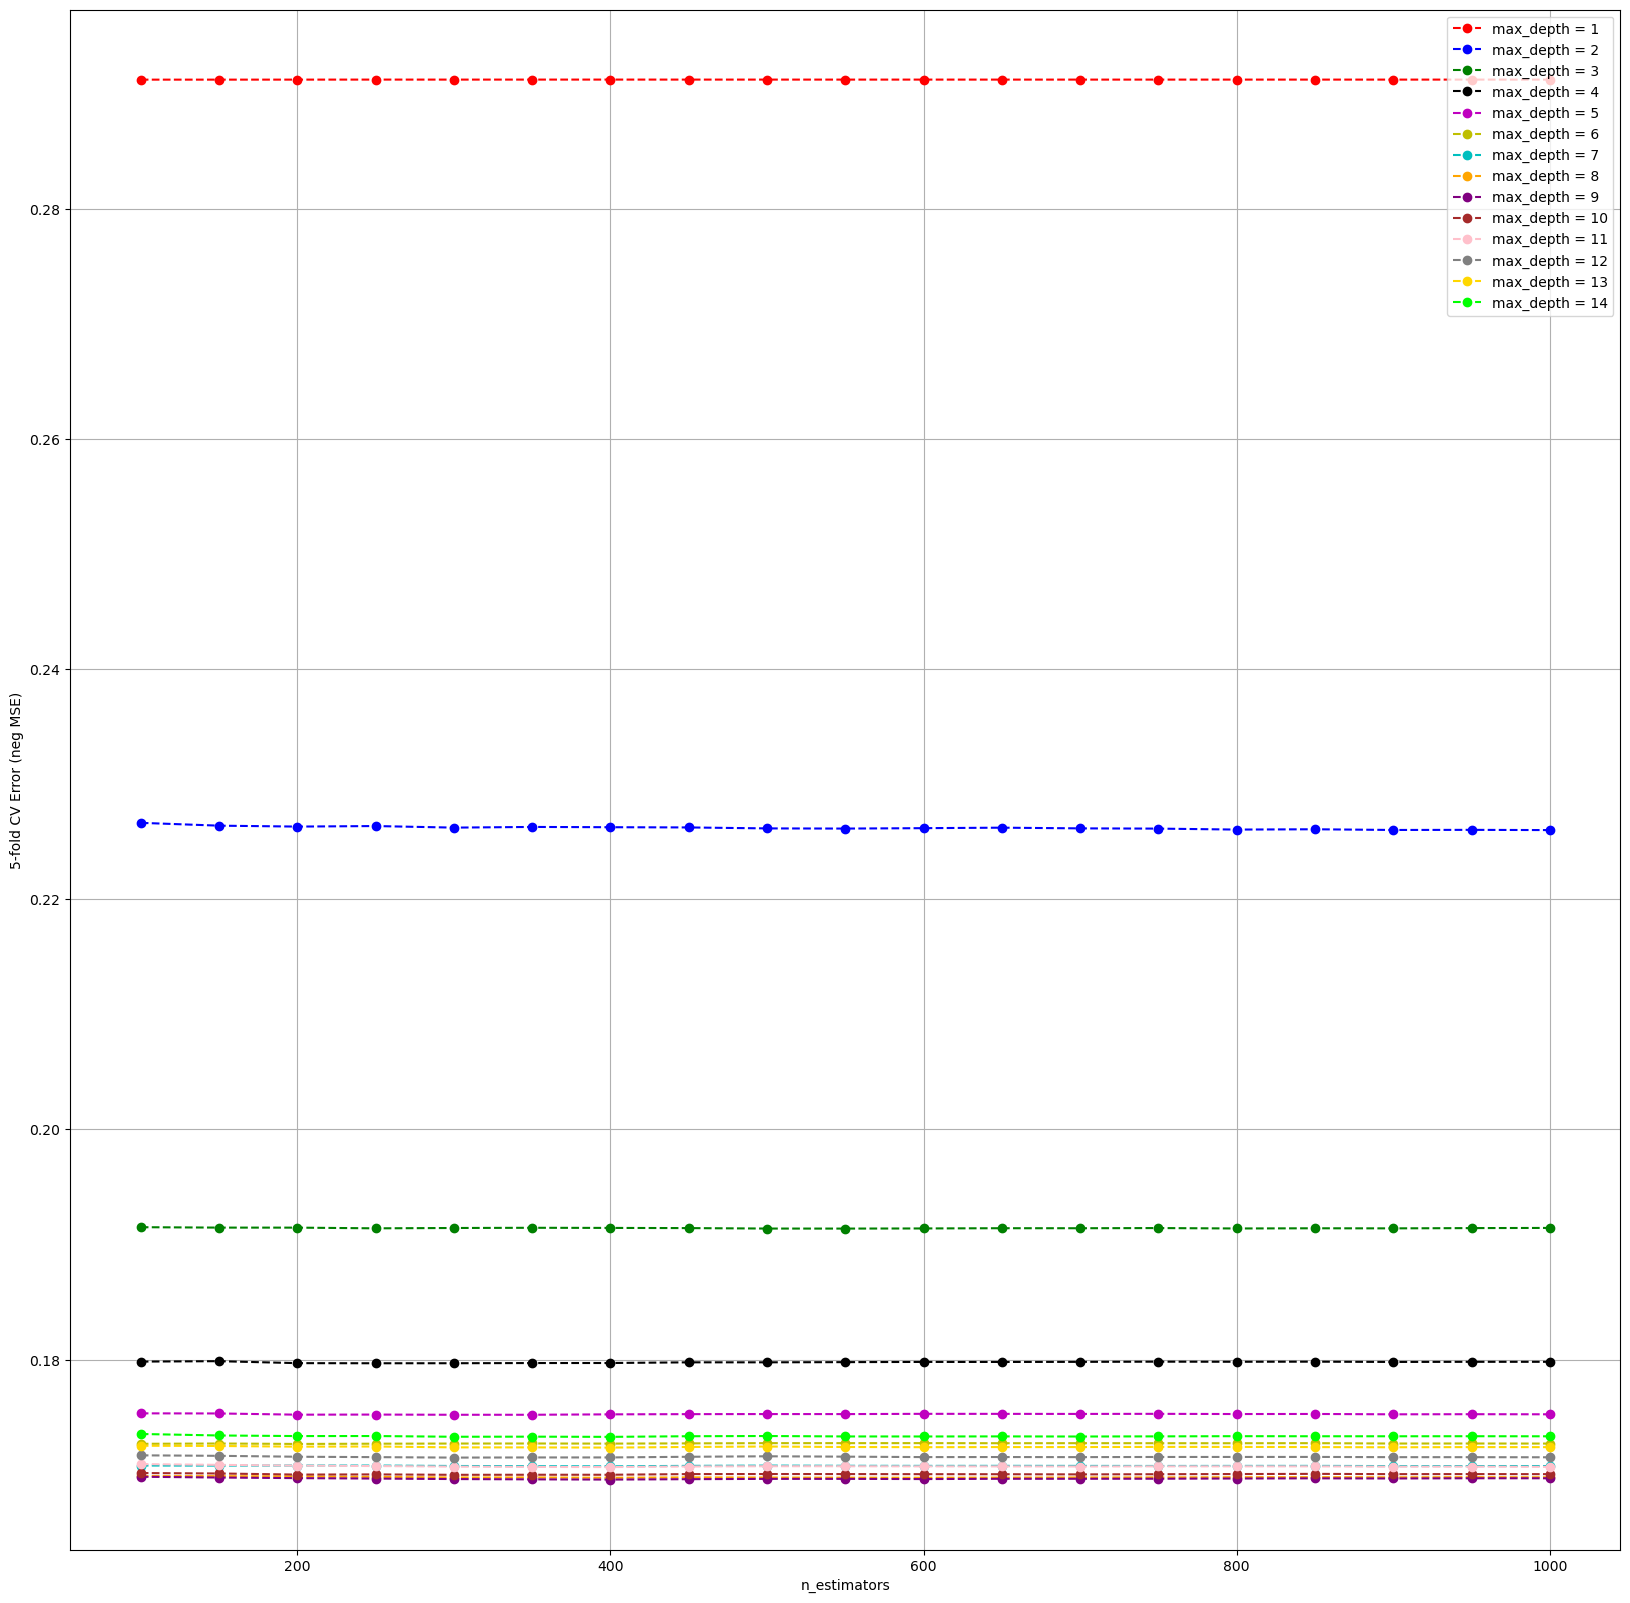

In [298]:
# Retrieve the mean test scores
error = -1 * grid.cv_results_['mean_test_score'].reshape(len(max_depth), len(n_estimators))
colors = ['r', 'b', 'g', 'k', 'm', 'y', 'c', 'orange', 'purple', 'brown', 'pink', 'gray', 'gold', 'lime']
plt.figure(figsize=(20, 20))

for i, depth in enumerate(max_depth):
    plt.plot(n_estimators, error[i, :], linestyle='--', marker='o', color=colors[i % len(colors)], label='max_depth = %g' % depth)

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('5-fold CV Error (neg MSE)')
plt.grid()
plt.show()


In [299]:
# Retrieve best parameters
maxDepth_best = grid.best_params_['max_depth']
n_estimator_best = grid.best_params_['n_estimators']

# Train the best model
rf_best = RandomForestRegressor(max_depth=maxDepth_best,n_estimators=n_estimator_best)
rf_best.fit(X_train,y_train)

# Print training and testing scores
print("Train: ",rf_best.score(X_train,y_train))
print("Test: ",rf_best.score(X_test,y_test))


Train:  0.7065392755750961
Test:  0.6650743765475682


<h3 style="background-color:#EBF5FB; color:#2471A3;">XGBoost</h3>

In [300]:
from xgboost import XGBRegressor

In [301]:
max_depth = range(1, 15)  
learning_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
tuned_parameters = {'max_depth': max_depth, 'learning_rate': learning_rate}

grid = GridSearchCV(XGBRegressor(n_estimators=200, random_state=0), 
                    scoring='neg_mean_squared_error', 
                    param_grid=tuned_parameters, 
                    cv=5, 
                    verbose=2)

grid.fit(X_train, y_train)

print("Best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))


Fitting 5 folds for each of 210 candidates, totalling 1050 fits
[CV] END ..................learning_rate=0.0001, max_depth=1; total time=   0.1s
[CV] END ..................learning_rate=0.0001, max_depth=1; total time=   0.0s
[CV] END ..................learning_rate=0.0001, max_depth=1; total time=   0.0s
[CV] END ..................learning_rate=0.0001, max_depth=1; total time=   0.0s
[CV] END ..................learning_rate=0.0001, max_depth=1; total time=   0.0s
[CV] END ..................learning_rate=0.0001, max_depth=2; total time=   0.1s
[CV] END ..................learning_rate=0.0001, max_depth=2; total time=   0.1s
[CV] END ..................learning_rate=0.0001, max_depth=2; total time=   0.1s
[CV] END ..................learning_rate=0.0001, max_depth=2; total time=   0.1s
[CV] END ..................learning_rate=0.0001, max_depth=2; total time=   0.1s
[CV] END ..................learning_rate=0.0001, max_depth=3; total time=   0.1s
[CV] END ..................learning_rate=0.00

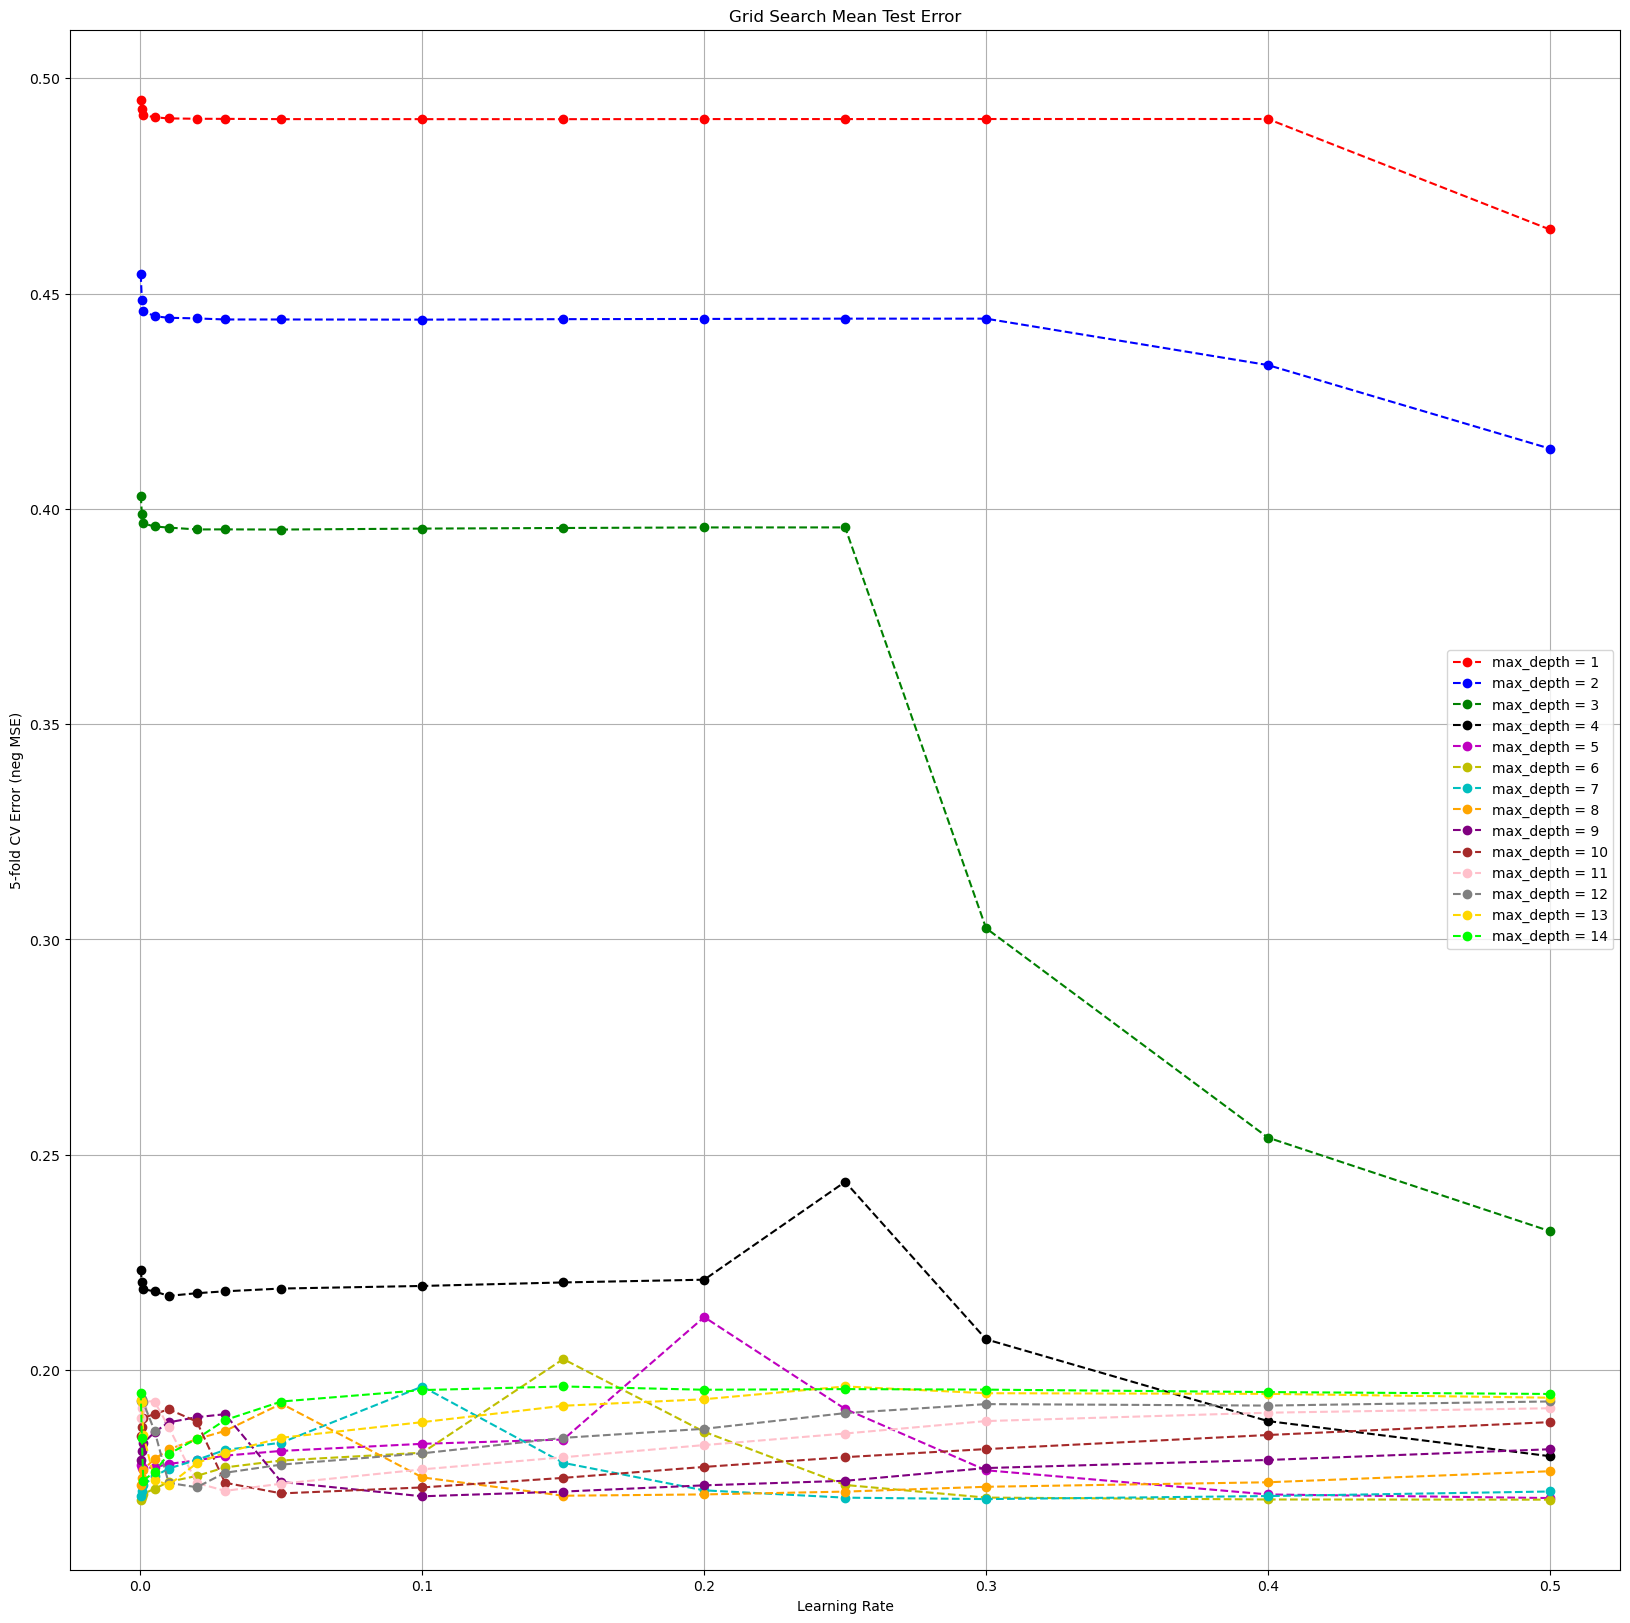

In [302]:
error = -1 * grid.cv_results_['mean_test_score'].reshape(len(max_depth), len(learning_rate))
colors = ['r', 'b', 'g', 'k', 'm', 'y', 'c', 'orange', 'purple', 'brown', 'pink', 'gray', 'gold', 'lime']
plt.figure(figsize=(20, 20))

for i, depth in enumerate(max_depth):
    plt.plot(learning_rate, error[i, :], linestyle='--', marker='o', 
             color=colors[i % len(colors)], label='max_depth = %g' % depth)

plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('5-fold CV Error (neg MSE)')
plt.grid()
plt.title('Grid Search Mean Test Error')
plt.show()

In [303]:
# Retrieve best parameters
max_depth_best = grid.best_params_['max_depth']
learning_rate_best = grid.best_params_['learning_rate']

# Train the best model
xgb_best = XGBRegressor(max_depth=max_depth_best, learning_rate=learning_rate_best, n_estimators=200, random_state=0)
xgb_best.fit(X_train, y_train)

# Print training and testing scores
print("Train score: ", xgb_best.score(X_train, y_train))
print("Test score: ", xgb_best.score(X_test, y_test))

Train score:  0.6948266302812799
Test score:  0.6663261670873788


<p style="background-color:#EBF5FB; color:#2471A3;">--------------------------------------------------------------------------------------------------------------------------------------------</p>

<h3 style="background-color:#EBF5FB; color:#2471A3;">General comments</h3>

Although the model's performance is not yet ideal, achieving a coefficient of determination (R²) of 0.67 on the test set with both Random Forest and XGBoost, the performance on the training set shows minimal difference—just a few hundredths for XGBoost and a few tenths for Random Forest. This indicates no overfitting and demonstrates strong generalizability to unseen data. A potential next step would be to dive deeper into feature engineering, for instance, by utilizing NLP modeling to extract insights from the text data.
  